### Basic importing of modules, clever loop for importing all raw data frames efficiently

#TO DO: try different percentage test size
#Look at top variables and decision boundaries
#Compare with literature again

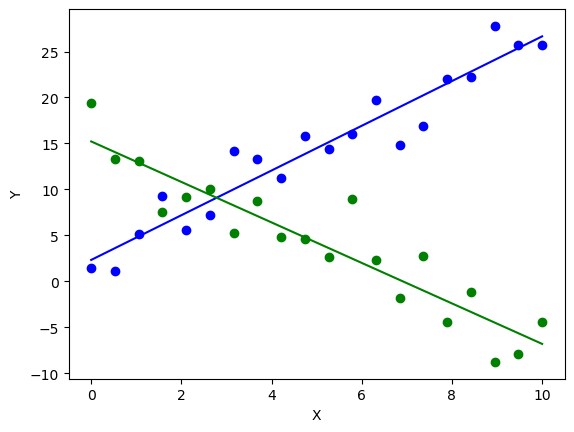

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Generate first dataset
x1 = np.linspace(0, 10, 20).reshape(-1, 1)
y1 = 3 * x1.flatten() + np.random.normal(0, 3, size=x1.shape[0])  # y = 3x + noise

# Generate second dataset
x2 = np.linspace(0, 10, 20).reshape(-1, 1)
y2 = -2 * x2.flatten() + 15 + np.random.normal(0, 3, size=x2.shape[0])  # y = -2x + 15 + noise

# Fit linear regression models
model1 = LinearRegression().fit(x1, y1)
model2 = LinearRegression().fit(x2, y2)

# Predictions
y1_pred = model1.predict(x1)
y2_pred = model2.predict(x2)

# Plot the datasets and regression lines
plt.scatter(x1, y1, label="Dataset 1", color="blue")
plt.plot(x1, y1_pred, label=f"Fit 1: y = {model1.coef_[0]:.2f}x + {model1.intercept_:.2f}", color="blue")

plt.scatter(x2, y2, label="Dataset 2", color="green")
plt.plot(x2, y2_pred, label=f"Fit 2: y = {model2.coef_[0]:.2f}x + {model2.intercept_:.2f}", color="green")

plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [2]:
import glob
import os
import copy
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.stats.multitest import multipletests
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from supertree import SuperTree
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# hide warnings


folder_paths = ["Controls", "LC", "ME"]

# Dictionaries to hold DataFrames and headers for each folder
all_dfs = {}
all_headers = {}
all_age_weight_height = {}

for path in folder_paths:
    csv_files = glob.glob(os.path.join(path, '*.xlsx'))
    print(csv_files)
    # Read data without headers, skipping the first 3 rows
    dfs = [pd.read_excel(file, header=None, skiprows=3) for file in csv_files]
    
    # Read the header row separately (the row just before the data starts, so skiprows=2)
    headers = [pd.read_excel(file, nrows=1, header=None) for file in csv_files]
    
    age_weight_height = [pd.read_excel(file, skiprows = 3, nrows=4, header=None, usecols = [1]) for file in csv_files] 
    # Assign the header row to each DataFrame
    for df, header in zip(dfs, headers):
        df.columns = header.iloc[0]
        
    # Store the DataFrames and headers in the dictionaries
    all_dfs[path] = dfs
    all_headers[path] = headers
    all_age_weight_height[path] = age_weight_height

# 23.2 seconds
# 23.7 seconds

['Controls\\P110061.xlsx', 'Controls\\P110090.xlsx', 'Controls\\P110096.xlsx', 'Controls\\P110097.xlsx', 'Controls\\P110098.xlsx', 'Controls\\P110099.xlsx', 'Controls\\P110101.xlsx', 'Controls\\P110102.xlsx', 'Controls\\P110103.xlsx', 'Controls\\P110104.xlsx', 'Controls\\P110106.xlsx', 'Controls\\P110107.xlsx', 'Controls\\P110109.xlsx', 'Controls\\P110110.xlsx', 'Controls\\P110112.xlsx', 'Controls\\P110114.xlsx', 'Controls\\P110115.xlsx', 'Controls\\P110126_P110126_CPET.xlsx', 'Controls\\P110132_P110132_CPET.xlsx', 'Controls\\P110139_P110139_CPET.xlsx', 'Controls\\P110140_110140_CPET.xlsx', 'Controls\\P110148_P110148_CPET.xlsx', 'Controls\\P110149_P110149_CPET.xlsx', 'Controls\\P110150_P110150_CPET.xlsx', 'Controls\\P110151_P110151_CPET.xlsx', 'Controls\\P110152_P110152_CPET.xlsx']
['LC\\P110017.xlsx', 'LC\\P110039.xlsx', 'LC\\P110050.xlsx', 'LC\\P110051.xlsx', 'LC\\P110055.xlsx', 'LC\\P110056.xlsx', 'LC\\P110058.xlsx', 'LC\\P110064.xlsx', 'LC\\P110085.xlsx', 'LC\\P110086.xlsx', 'LC\\P

### Create a copy of the grouped data frame to work with, to avoid having to import all the data frames over and over again

In [3]:
all_dfs_c = {'Controls':[], 'LC':[], 'ME':[]}
groups = ['Controls', 'LC', 'ME']
for group in groups:
    group_list = []
    for df in all_dfs[group]:
        group_list.append(df.copy())
    all_dfs_c[group] = group_list


# Count the amount of dataframes with missing columns_to_keep, and identify missing columns
cols_to_use = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Phase']
count = {col: 0 for col in cols_to_use}
no_count = {col: 0 for col in cols_to_use}
for group_name, group in all_dfs_c.items():
    for df in group:
        for col in cols_to_use:
            if col in df.columns:
                count[col] += 1
            else:
                no_count[col] += 1
print(count)
print(no_count)
for i in no_count:
    if no_count[i] > 0:
        print(i)
        print(no_count[i])


# Remove unwanted columns, and subsequently removing NaN's
for group_name, group in all_dfs_c.items():
    for df in group:
        col_rem_2b = [col for col in df.columns if col not in cols_to_use]
        df.drop(columns = col_rem_2b, inplace = True)

for group_name, group in all_dfs_c.items():
    for df in group:
        df.dropna(inplace=True)
Control = all_dfs_c['Controls']
LC = all_dfs_c['LC']
ME = all_dfs_c['ME']

for groupname, group in all_dfs_c.items():
    for i,df in enumerate(group):
        df['Participant'] = f'{groupname}_{i}'

Control_ahw = pd.DataFrame()
LC_ahw = pd.DataFrame()
ME_ahw = pd.DataFrame()

for groupname, group in all_age_weight_height.items():
    for i, df in enumerate(group):
        df = df.T
        df.columns = ['Gender', 'Age', 'Height', 'Weight']
        df['Participant'] = f'{groupname}_{i}'
        if groupname == 'Controls':
            Control_ahw = pd.concat([Control_ahw, df])
        elif groupname == 'LC':
            LC_ahw = pd.concat([LC_ahw, df])
        elif groupname == 'ME':
            ME_ahw = pd.concat([ME_ahw, df])


# Concat all dataframes of a single participant group, and change the column order
Control_df = pd.concat((Control), axis = 0)
LC_df = pd.concat((LC), axis = 0)
ME_df = pd.concat((ME), axis = 0)

col_order = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Participant', 'Phase']
Control_df = Control_df[col_order]
LC_df = LC_df[col_order]
ME_df = ME_df[col_order]


# Convert the time column to seconds
def hhmmss_to_seconds(hhmmss):
    h, m, s = map(int, hhmmss.split(':'))
    return h * 3600 + m * 60 + s

for df in [Control_df, LC_df, ME_df]:
    df['t'] = df['t'].astype('string')
    df['t'] = df['t'].apply(hhmmss_to_seconds)


# Remove rows where the participant is not exercising (See paper for more information)
Control_df_edit = copy.deepcopy(Control_df)
ME_df_edit = copy.deepcopy(ME_df)
edit_c = dict(zip(['Controls_' + str(i) for i in range(21,26)], [190, 388, 331, 412, 290]))

edit_ME = dict(zip(['ME_' + str(i) for i in range(22,26)], [318, 332, 350, 238]))
Control_df_edit.reset_index(inplace = True)
ME_df_edit.reset_index(inplace = True)
for edit, df in zip([edit_c, edit_ME], [Control_df_edit, ME_df_edit]):
    to_drop = []
    for participant in edit.keys():
        start_exercise = df.groupby('Participant').head(1).index.tolist()[int(participant[-2:])]
        end_exercise = start_exercise + edit[participant]
        end_trial = df.groupby('Participant').tail(1).index.tolist()[int(participant[-2:])]
        to_drop += list(df.index[end_exercise:end_trial+1])
    df.drop(to_drop, inplace = True)
    df.set_index('index', inplace = True)



# FIXING GROUP DATA POINTS
Control_df_edit.reset_index(inplace = True)
Control_df_edit.drop(columns = 'index', inplace = True)

# Fix HR 
Control_df_edit.loc[666:678, 'HR'] = Control_df_edit.loc[666:678, 'HR'].apply(lambda x: 84 if x < 50 else x)
HR299 = Control_df_edit[Control_df_edit['HR'] < 50].index
if HR299.size > 0:
    Control_df_edit.loc[HR299[0], 'HR'] = np.mean([Control_df_edit['HR'][HR299[0]+1],Control_df_edit['HR'][HR299[0]-1]])

LC_df_edit = copy.deepcopy(LC_df)
LC_df_edit.reset_index(inplace = True)
LC_df_edit.drop(columns = 'index', inplace = True)
LC_df_edit['HR'].replace(0, np.nan, inplace=True)

ME_df_edit.reset_index(inplace = True)
ME_df_edit.drop(columns = 'index', inplace = True)

#for i in ME_df_edit['Participant'].unique():
#    print(ME_df_edit.loc[:2700][(ME_df_edit.loc[:2700]['Participant'] == i) & (ME_df_edit.loc[:2700]['HR'] < 70)]['HR'])
ME_df_edit['HR'].replace(0, np.nan, inplace=True)

# Replace values in 'HR' column that are less than 80 with NaN in the first 2700 rows
ME_df_edit.loc[:2700, 'HR'] = ME_df_edit.loc[:2700, 'HR'].mask(ME_df_edit.loc[:2700, 'HR'] < 80, np.nan)


{'t': 63, 'Power': 63, 'HR': 60, 'VE': 63, 'VO2': 63, 'VCO2': 63, 'PetCO2': 63, 'PetO2': 63, 'VO2/Kg': 63, 'VE/VO2': 63, 'VE/VCO2': 63, 'RQ': 63, 'VT': 63, 'Rf': 63, 'Ti': 63, 'Te': 63, 'Phase': 63}
{'t': 0, 'Power': 0, 'HR': 3, 'VE': 0, 'VO2': 0, 'VCO2': 0, 'PetCO2': 0, 'PetO2': 0, 'VO2/Kg': 0, 'VE/VO2': 0, 'VE/VCO2': 0, 'RQ': 0, 'VT': 0, 'Rf': 0, 'Ti': 0, 'Te': 0, 'Phase': 0}
HR
3


##### Fixing Control Data

In [4]:
%%capture
# Fix VE/VO2
def find_large_increments(list, increment):
    result = []
    for i in range(1, len(list)):
        if list[i] - list[i-1] > increment:
            result.append(i)
    return result
vevo2_incr = find_large_increments(Control_df_edit['VE/VO2'], 25)
plt.plot(Control_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, Control_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    Control_df_edit.loc[i, 'VE/VO2'] = Control_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(Control_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

# Fix VE/VCO2
plt.figure()
vevco2_incr = find_large_increments(Control_df_edit['VE/VCO2'], 25)
plt.plot(Control_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, Control_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    Control_df_edit.loc[i, 'VE/VCO2'] = Control_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(Control_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

# Fix Ti
plt.figure()
plt.plot(Control_df_edit['Ti'])
ti_incr = find_large_increments(Control_df_edit['Ti'], 2.5)
plt.scatter(ti_incr, Control_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    Control_df_edit.loc[i, 'Ti'] = Control_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(Control_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

# Fix Te
te_incr = find_large_increments(Control_df_edit['Te'], 2.5)
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.scatter(te_incr, Control_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
te_incr = find_large_increments(Control_df_edit['Te'], 4)
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

##### Fixing LC data    

In [5]:
%%capture
vevo2_incr = find_large_increments(LC_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, LC_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    LC_df_edit.loc[i, 'VE/VO2'] = LC_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')    

vevco2_incr = find_large_increments(LC_df_edit['VE/VCO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, LC_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    LC_df_edit.loc[i, 'VE/VCO2'] = LC_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

tv_incr = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incr, LC_df_edit['VT'][tv_incr], color = 'red')
plt.title('Tidal Volume (VT) before correction')
for i in tv_incr:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
tv_incra = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incra, LC_df_edit['VT'][tv_incra], color = 'red')
plt.title('Tidal Volume (VT) After 1st correction')
for i in tv_incra:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.title('Tidal Volume (VT) After 2nd correction')


ti_incr = find_large_increments(LC_df_edit['Ti'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.scatter(ti_incr, LC_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    LC_df_edit.loc[i, 'Ti'] = LC_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) after 1st correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.title('Expiratory Time (Te) after 2nd correction')


##### Fixing ME data
    

In [6]:
%%capture

vevo2_incr = find_large_increments(ME_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, ME_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    ME_df_edit.loc[i, 'VE/VO2'] = ME_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

vevco2_incr = find_large_increments(ME_df_edit['VE/VCO2'], 28)
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, ME_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    ME_df_edit.loc[i, 'VE/VCO2'] = ME_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

ti_incr = find_large_increments(ME_df_edit['Ti'], 3)
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.scatter(ti_incr, ME_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    ME_df_edit.loc[i, 'Ti'] = ME_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(ME_df_edit['Te'], 3)
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.scatter(te_incr, ME_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    ME_df_edit.loc[i, 'Te'] = ME_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

Remove initial time score from data


In [7]:
df_edit = pd.concat([Control_df_edit, LC_df_edit, ME_df_edit], axis=0)
df_edit.set_index('Participant', inplace=True)
df_exercise = df_edit[df_edit['Phase'] == 'EXERCISE']
df_exercise.drop(columns = 'Phase', inplace = True)
# remove starting time of a participant from all other time values for that participant
for participant in df_exercise.index.unique():
    df_exercise.loc[df_exercise.index == participant, 't'] = df_exercise.loc[df_exercise.index == participant, 't'] - df_exercise.loc[df_exercise.index == participant, 't'].min()
    

### Filling in missing HR data per group using a randomforestregressor


[LightGBM] [Warning] feature_fraction is set=0.8853200783693815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8853200783693815
[LightGBM] [Warning] lambda_l1 is set=0.002391476762117074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002391476762117074
[LightGBM] [Warning] lambda_l2 is set=6.670854697302184e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670854697302184e-08
[LightGBM] [Warning] bagging_fraction is set=0.6359968773396683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6359968773396683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8853200783693815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8853200783693815
[LightGBM] [Warning] lambda_l1 is set=0.002391476762117074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002391476762117074
[LightGBM] [Warning] la

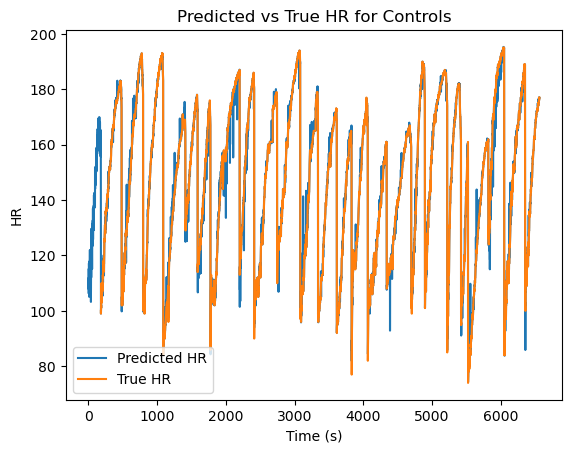

[LightGBM] [Warning] feature_fraction is set=0.8853200783693815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8853200783693815
[LightGBM] [Warning] lambda_l1 is set=0.002391476762117074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002391476762117074
[LightGBM] [Warning] lambda_l2 is set=6.670854697302184e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670854697302184e-08
[LightGBM] [Warning] bagging_fraction is set=0.6359968773396683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6359968773396683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.9692548447126131
Before filling missing values: 181
After filling missing values with predicted values: 0
[LightGBM] [Warning] feature_fraction is set=0.7415418698901909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7415418698901909
[LightGBM] [Warning] lambda_l1 is set=9.851229100898

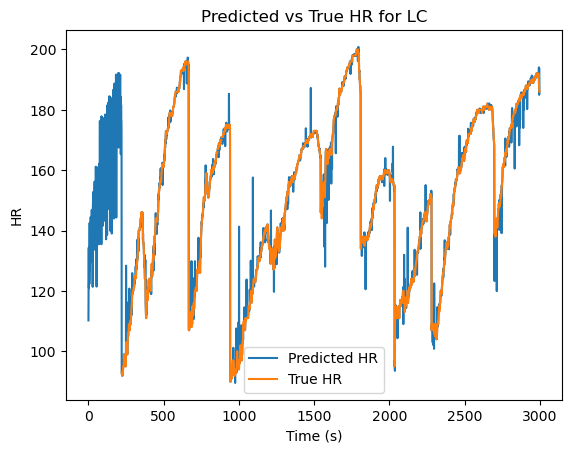

[LightGBM] [Warning] feature_fraction is set=0.7415418698901909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7415418698901909
[LightGBM] [Warning] lambda_l1 is set=9.851229100898672e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.851229100898672e-05
[LightGBM] [Warning] lambda_l2 is set=2.502653723617393e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.502653723617393e-05
[LightGBM] [Warning] bagging_fraction is set=0.6412727255294189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6412727255294189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.9529683078456421
Before filling missing values: 234
After filling missing values with predicted values: 0
[LightGBM] [Warning] feature_fraction is set=0.7695358085120094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695358085120094
[LightGBM] [Warning] lambda_l1 is set=0.0002125631

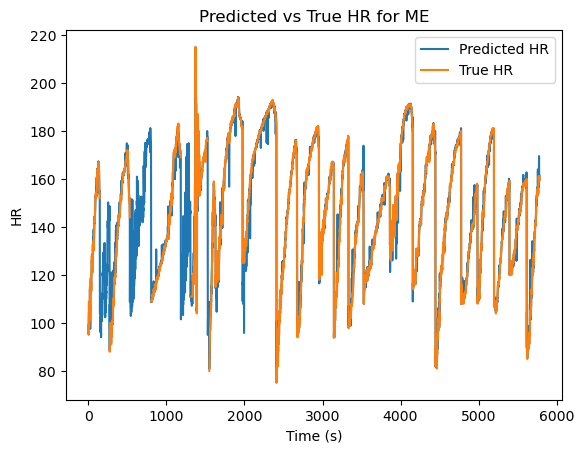

[LightGBM] [Warning] feature_fraction is set=0.7695358085120094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695358085120094
[LightGBM] [Warning] lambda_l1 is set=0.0002125631923487339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002125631923487339
[LightGBM] [Warning] lambda_l2 is set=4.660716343527813e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.660716343527813e-07
[LightGBM] [Warning] bagging_fraction is set=0.9008281949963505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008281949963505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.9536017735455561
Before filling missing values: 540
After filling missing values with predicted values: 0


In [8]:
# through optuna established hard coded best parameters for the model
Co_params = {'lambda_l1': 0.002391476762117074, 'lambda_l2': 6.670854697302184e-08, 'num_leaves': 248, 'feature_fraction': 0.8853200783693815, 'bagging_fraction': 0.6359968773396683, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.053271560997448356, 'n_estimators': 519}
LC_params = {'lambda_l1': 9.851229100898672e-05, 'lambda_l2': 2.502653723617393e-05, 'num_leaves': 55, 'feature_fraction': 0.7415418698901909, 'bagging_fraction': 0.6412727255294189, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.06987538819668111, 'n_estimators': 814}
ME_params = {'lambda_l1': 0.0002125631923487339, 'lambda_l2': 4.660716343527813e-07, 'num_leaves': 119, 'feature_fraction': 0.7695358085120094, 'bagging_fraction': 0.9008281949963505, 'bagging_freq': 6, 'min_child_samples': 5, 'learning_rate': 0.026336541820438972, 'n_estimators': 587}
params = {'Controls': Co_params, 'LC': LC_params, 'ME': ME_params}
# Split the data into features and target
# train a linear regression model to predict HR
np.random.seed(42)
for groupname in df_exercise.index.str.split('_').str[0].unique():
    df = df_exercise[df_exercise.index.str.contains(groupname)]
    df.reset_index(inplace = True)
    missing_start_n = df['HR'].isna().sum()
    df_dropped = df.dropna()
    X = df_dropped.drop(columns = ['HR', 'Participant'])
    y = df_dropped['HR']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = lgb.LGBMRegressor(**params[groupname])
    model.fit(X_train_scaled, y_train)
    #predict HR for the entire dataset
    HR_pred = model.predict(scaler.transform(df.drop(columns = ['HR', 'Participant'])))
    plt.figure()
    # plot predicted values and true values in one plot against index
    plt.plot(HR_pred, label='Predicted HR')
    plt.plot(df['HR'], label='True HR')
    plt.title(f'Predicted vs True HR for {groupname}')
    plt.xlabel('Time (s)')
    plt.ylabel('HR')
    plt.legend()
    plt.show()
    # print score
    print(model.score(X_test_scaled, y_test))
    print(f'Before filling missing values: {missing_start_n}')
    # fill missing values with predicted values
    df.loc[df['HR'].isna(), 'HR'] = HR_pred[df['HR'].isna()]
    print(f'After filling missing values with predicted values: {df["HR"].isna().sum()}')
    df.set_index('Participant', inplace=True)
    df_exercise.loc[df_exercise.index.str.contains(groupname), 'HR'] = df['HR']
    

In [9]:
# bin the data to the length of the shortest participant to create equal length sequences
min_lengths = df_exercise.groupby('Participant')['t'].count().sort_values().tail(14).min()
df_binned = pd.DataFrame()
for participant in df_exercise.index.unique():
    participant_data = df_exercise[df_exercise.index == participant]
    if participant_data['t'].count() > min_lengths:
        participant_df_binned = pd.DataFrame()
        for feature in participant_data.columns:
            bins = pd.cut(participant_data[feature], min_lengths)
            unique_bins = bins.cat.categories
            bins = [bin.mid for bin in unique_bins]
            participant_df_binned[feature] = bins
    else:
        participant_df_binned = participant_data
    participant_df_binned['Participant'] = participant
    df_binned = pd.concat([df_binned, participant_df_binned], axis=0)

# normalize time per participant between 0 and 1
#for participant in df_binned['Participant'].unique():
#    df_binned.loc[df_binned['Participant'] == participant, 't'] = df_binned.loc[df_binned['Participant'] == participant, 't'] / df_binned.loc[df_binned['Participant'] == participant, 't'].max()
df_exercise.reset_index(inplace = True)
# place participant column at the end of the dataframe
participants = df_exercise.pop('Participant')
df_exercise['Participant'] = participants
df_exercise['Group'] = df_exercise['Participant'].str.split('_').str[0]
Co_exercise = df_exercise[df_exercise['Participant'].str.contains('Controls')]
LC_exercise = df_exercise[df_exercise['Participant'].str.contains('LC')]
ME_exercise = df_exercise[df_exercise['Participant'].str.contains('ME')]
for group_name, df_group in zip(['Controls', 'LC', 'ME'], [Co_exercise, LC_exercise, ME_exercise]):     
    df_group.to_csv(f'{group_name}.data', sep=',', index = False)

#### Creating Summary statistics


In [10]:
# create a new dataframe for ME with the following summary statistics for each participant: mean + 90th percentile for VO2/kg, vco2/kg, HR, VE, PetCO2, PetO2, VT, Rf, Rq, and mean + 10th percentile for VE/VO2, VE/VCO2, Ti, Te, and exercise time, and mean and max power
DF_summary = pd.DataFrame()
#df = pd.concat([ME_exercise, LC_exercise, Co_exercise], axis=0)
df = pd.DataFrame()
for dfs in [Co_exercise, LC_exercise, ME_exercise]:
    dfs['Group'] = dfs['Participant'].str.split('_').str[0]
    df = pd.concat([df, dfs])

# add empty columns for each feature
DF_summary = df[['Participant', 'Group']].drop_duplicates().reset_index(drop=True)
ahw_df = pd.concat([Control_ahw, LC_ahw, ME_ahw], axis=0).reset_index(drop=True)
DF_summary = pd.merge(DF_summary, ahw_df, on='Participant', how='left')
DF_summary.set_index('Participant', inplace=True)
for feature in ['Power', 'HR', 'VE/VCO2', 'VO2', 't']:
    if feature == 'Power':
        DF_summary[feature] = df.groupby('Participant')[feature].max()
    else:
        DF_summary[f'{feature}_max'] = df.groupby('Participant')[feature].max()
for feature in ['VO2/Kg', 'HR', 'VE', 'PetCO2', 'PetO2', 'VT', 'Rf', 'RQ', 'VE/VO2', 'VE/VCO2']:
    DF_summary[f'{feature}_mean'] = df.groupby('Participant')[feature].mean()
    DF_summary[f'{feature}_95th_percentile'] = df.groupby('Participant')[feature].quantile(0.95)
for feature in ['Ti', 'Te']:
    DF_summary[f'{feature}_mean'] = df.groupby('Participant')[feature].mean()
    DF_summary[f'{feature}_5th_percentile'] = df.groupby('Participant')[feature].quantile(0.05)

DF_summary['Gender'] = DF_summary['Gender'].map({'Female': 1, 'Male': 0})

# Wasserman equation is VO2 = 0.046*Height - 0.021*Age - 0.62 * gender - 4.31; with gender being 0 for female and 1 for male
DF_summary['VO2_pred'] = 0.046*DF_summary['Height'] - 0.021*DF_summary['Age'] - 0.62*DF_summary['Gender'] - 4.31
DF_summary['PetCO2_5th_percentile'] = df.groupby('Participant')['PetCO2'].quantile(0.1)
DF_summary['PetO2_5th_percentile'] = df.groupby('Participant')['PetO2'].quantile(0.1)

DF_summary['PetCO2_diff'] = DF_summary['PetCO2_95th_percentile'] - DF_summary['PetCO2_5th_percentile']
DF_summary['PetO2_diff'] = DF_summary['PetO2_95th_percentile'] - DF_summary['PetO2_5th_percentile']
DF_summary['HR_pred'] = 220 - DF_summary['Age']
# O2pulse by dividing VO2max by HRMax
DF_summary['O2_pulse'] = DF_summary['VO2_max']/ DF_summary['HR_max']
DF_summary['O2_pulse_pred'] = DF_summary['VO2_pred'] / DF_summary['HR_pred']
DF_summary['Power/kg'] = DF_summary['Power'] / DF_summary['Weight']

# HR at rest is the lowest HR value in the first 10 percent of the exercise
DF_summary['HR_rest'] = df.groupby('Participant')['HR'].apply(lambda x: x.head(int(len(x)*0.1)).min())
DF_summary['VE/VCO2_start_mean'] = df.groupby('Participant')['VE/VCO2'].apply(lambda x: x.head(int(len(x)*0.4)).mean())
DF_summary['RER end_peak'] = df.groupby('Participant')['RQ'].apply(lambda x: x.tail(int(len(x)*0.05)).max())



In [11]:
Markers_summary = pd.DataFrame()
Markers_summary['Participant'] = DF_summary.index
Markers_summary.set_index('Participant', inplace=True) 

Markers_summary['VO2/VO2_pred < 0.8 marker'] = DF_summary['VO2_max']/1000 / DF_summary['VO2_pred'] < 0.8
Markers_summary['aerobic capacity < 8 marker'] = DF_summary['VO2_max'] / DF_summary['Power'] < 8
Markers_summary['O2pulse < 13 marker'] = DF_summary['O2_pulse'] < 13
Markers_summary['Chronotropic incompetence marker'] = (DF_summary['HR_max'] - DF_summary['HR_rest']) / (220 - DF_summary['Age'] - DF_summary['HR_rest']) < 0.8
Markers_summary['Ventilatory slope > 35 Marker'] = DF_summary['VE/VCO2_start_mean'] > 35
# max HR < 90% of predicted HR
Markers_summary['HR_max < 85% HR_pred marker'] = DF_summary['HR_max'] < 0.85*DF_summary['HR_pred']
# oxygen pulse less than 80% of predicted oxygen pulse
Markers_summary['O2_pulse < 70% O2_pulse_pred marker'] = DF_summary['O2_pulse'] < 0.7*DF_summary['O2_pulse_pred']
Markers_summary['RER < 1.05 marker'] = DF_summary['RER end_peak'] < 1.05
Markers_summary['PetCO2_diff < 3 marker'] = DF_summary['PetCO2_diff'] < 3
Markers_summary['PetO2_diff < 0.5 marker'] = DF_summary['PetO2_diff'] < 0.5
Markers_summary['PetCO2_90th_percentile < 30 marker'] = (DF_summary['PetCO2_95th_percentile'] < 30)
n_markers = Markers_summary.columns[Markers_summary.columns.str.endswith('marker')]
f_markers = Markers_summary[n_markers].sum() == 0
f_markers = f_markers[f_markers == True].index
Markers_summary.drop(columns=f_markers, inplace=True)
n_markers = Markers_summary.columns[Markers_summary.columns.str.endswith('marker')]
Markers_summary['Summary'] = Markers_summary.iloc[:, -len(n_markers):].sum(axis=1)
Markers_summary['Group'] = DF_summary['Group']


perform_sum = pd.DataFrame()
perform_sum['Participant'] = DF_summary.index
perform_sum.set_index('Participant', inplace=True)
perform_sum = pd.merge(perform_sum, DF_summary[['Power/kg', 'VO2/Kg_mean', 'VO2/Kg_95th_percentile']], on='Participant', how='left')


# cluster the participants based on performance
scaler = StandardScaler()
perform_sum_scaled = scaler.fit_transform(perform_sum)
kmeans = KMeans(n_clusters=3, random_state=42)
perform_sum['Cluster_temp'] = kmeans.fit_predict(perform_sum_scaled)
perform_sum['Cluster'] = perform_sum['Cluster_temp']
lowest_vo2_cluster = perform_sum.loc[perform_sum['VO2/Kg_mean'].idxmin(), 'Cluster_temp']
highest_vo2_cluster = perform_sum.loc[perform_sum['VO2/Kg_mean'].idxmax(), 'Cluster_temp']
for cl in [0, 1, 2]:
    if cl != lowest_vo2_cluster and cl != highest_vo2_cluster:
        mid_cluster = cl
        break
mapping = {lowest_vo2_cluster: 0, mid_cluster: 1, highest_vo2_cluster: 2}
perform_sum['Cluster'] = perform_sum['Cluster_temp'].map(mapping)
perform_sum.drop(columns='Cluster_temp', inplace=True)
DF_summary['Cluster'] = perform_sum['Cluster']


Group     Fitness
Controls  Fit        22
          Unfit       4
LC        Fit         7
          Unfit       4
ME        Fit         7
          Unfit      19
Name: Participant, dtype: int64


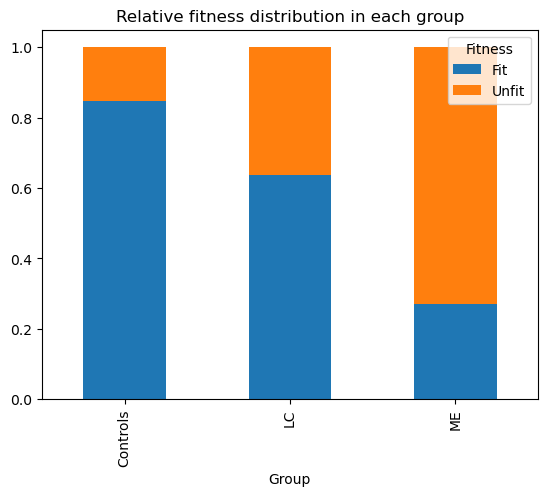

In [12]:

# sort groups based on their cluster, cluster 2 goes into fit groups, cluster 0 goes into unfit groups
DF_summary['Fitness'] = DF_summary['Cluster'].map({2: 'Fit', 1: 'Fit', 0: 'Unfit'})
DF_summary.reset_index(inplace=True)
print(DF_summary.groupby(['Group', 'Fitness'])['Participant'].count())
grouped = DF_summary.groupby(['Group', 'Fitness'])['Participant'].count().unstack()
normalized = grouped.div(grouped.sum(axis=1), axis=0)
normalized.plot(kind='bar', stacked=True)
plt.title('Relative fitness distribution in each group')

DF_summary.set_index('Participant', inplace=True)

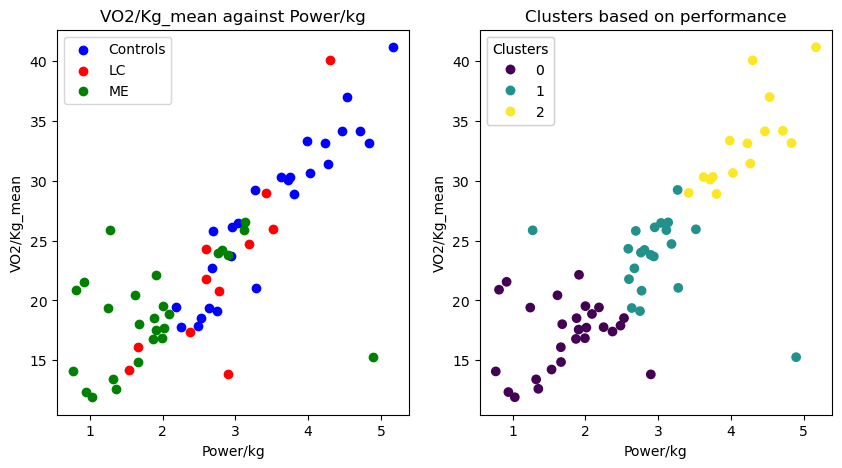

In [13]:
# plot VO2 kg against power for each group in a scatter plot; use a single plot with legend
fig, ax = plt.subplots(1,2, figsize=(10, 5))

Mar_co = Markers_summary[Markers_summary['Group'] == 'Controls']
Mar_LC = Markers_summary[Markers_summary['Group'] == 'LC']
Mar_ME = Markers_summary[Markers_summary['Group'] == 'ME']
Co_sum = DF_summary[DF_summary['Group'] == 'Controls']
LC_sum = DF_summary[DF_summary['Group'] == 'LC']
ME_sum = DF_summary[DF_summary['Group'] == 'ME']
# create a list of colours for each group
colour = ['blue', 'red', 'green']
i = 0
for group_name, df in zip(['Controls', 'LC', 'ME'], [Co_sum, LC_sum, ME_sum]):
    ax[0].scatter(df['Power/kg'], df['VO2/Kg_mean'], label=f'{df["Group"].iloc[0]}', color=colour[i])
    ax[0].set_xlabel('Power/kg')
    ax[0].set_ylabel('VO2/Kg_mean')
    ax[0].legend()
    ax[0].set_title('VO2/Kg_mean against Power/kg')
    i += 1       
scatter = ax[1].scatter(perform_sum['Power/kg'], perform_sum['VO2/Kg_mean'], c=DF_summary['Cluster'], cmap='viridis')
legend1 = ax[1].legend(*scatter.legend_elements(), title="Clusters")
ax[1].add_artist(legend1)
plt.xlabel('Power/kg')
plt.ylabel('VO2/Kg_mean')
plt.title('Clusters based on performance')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


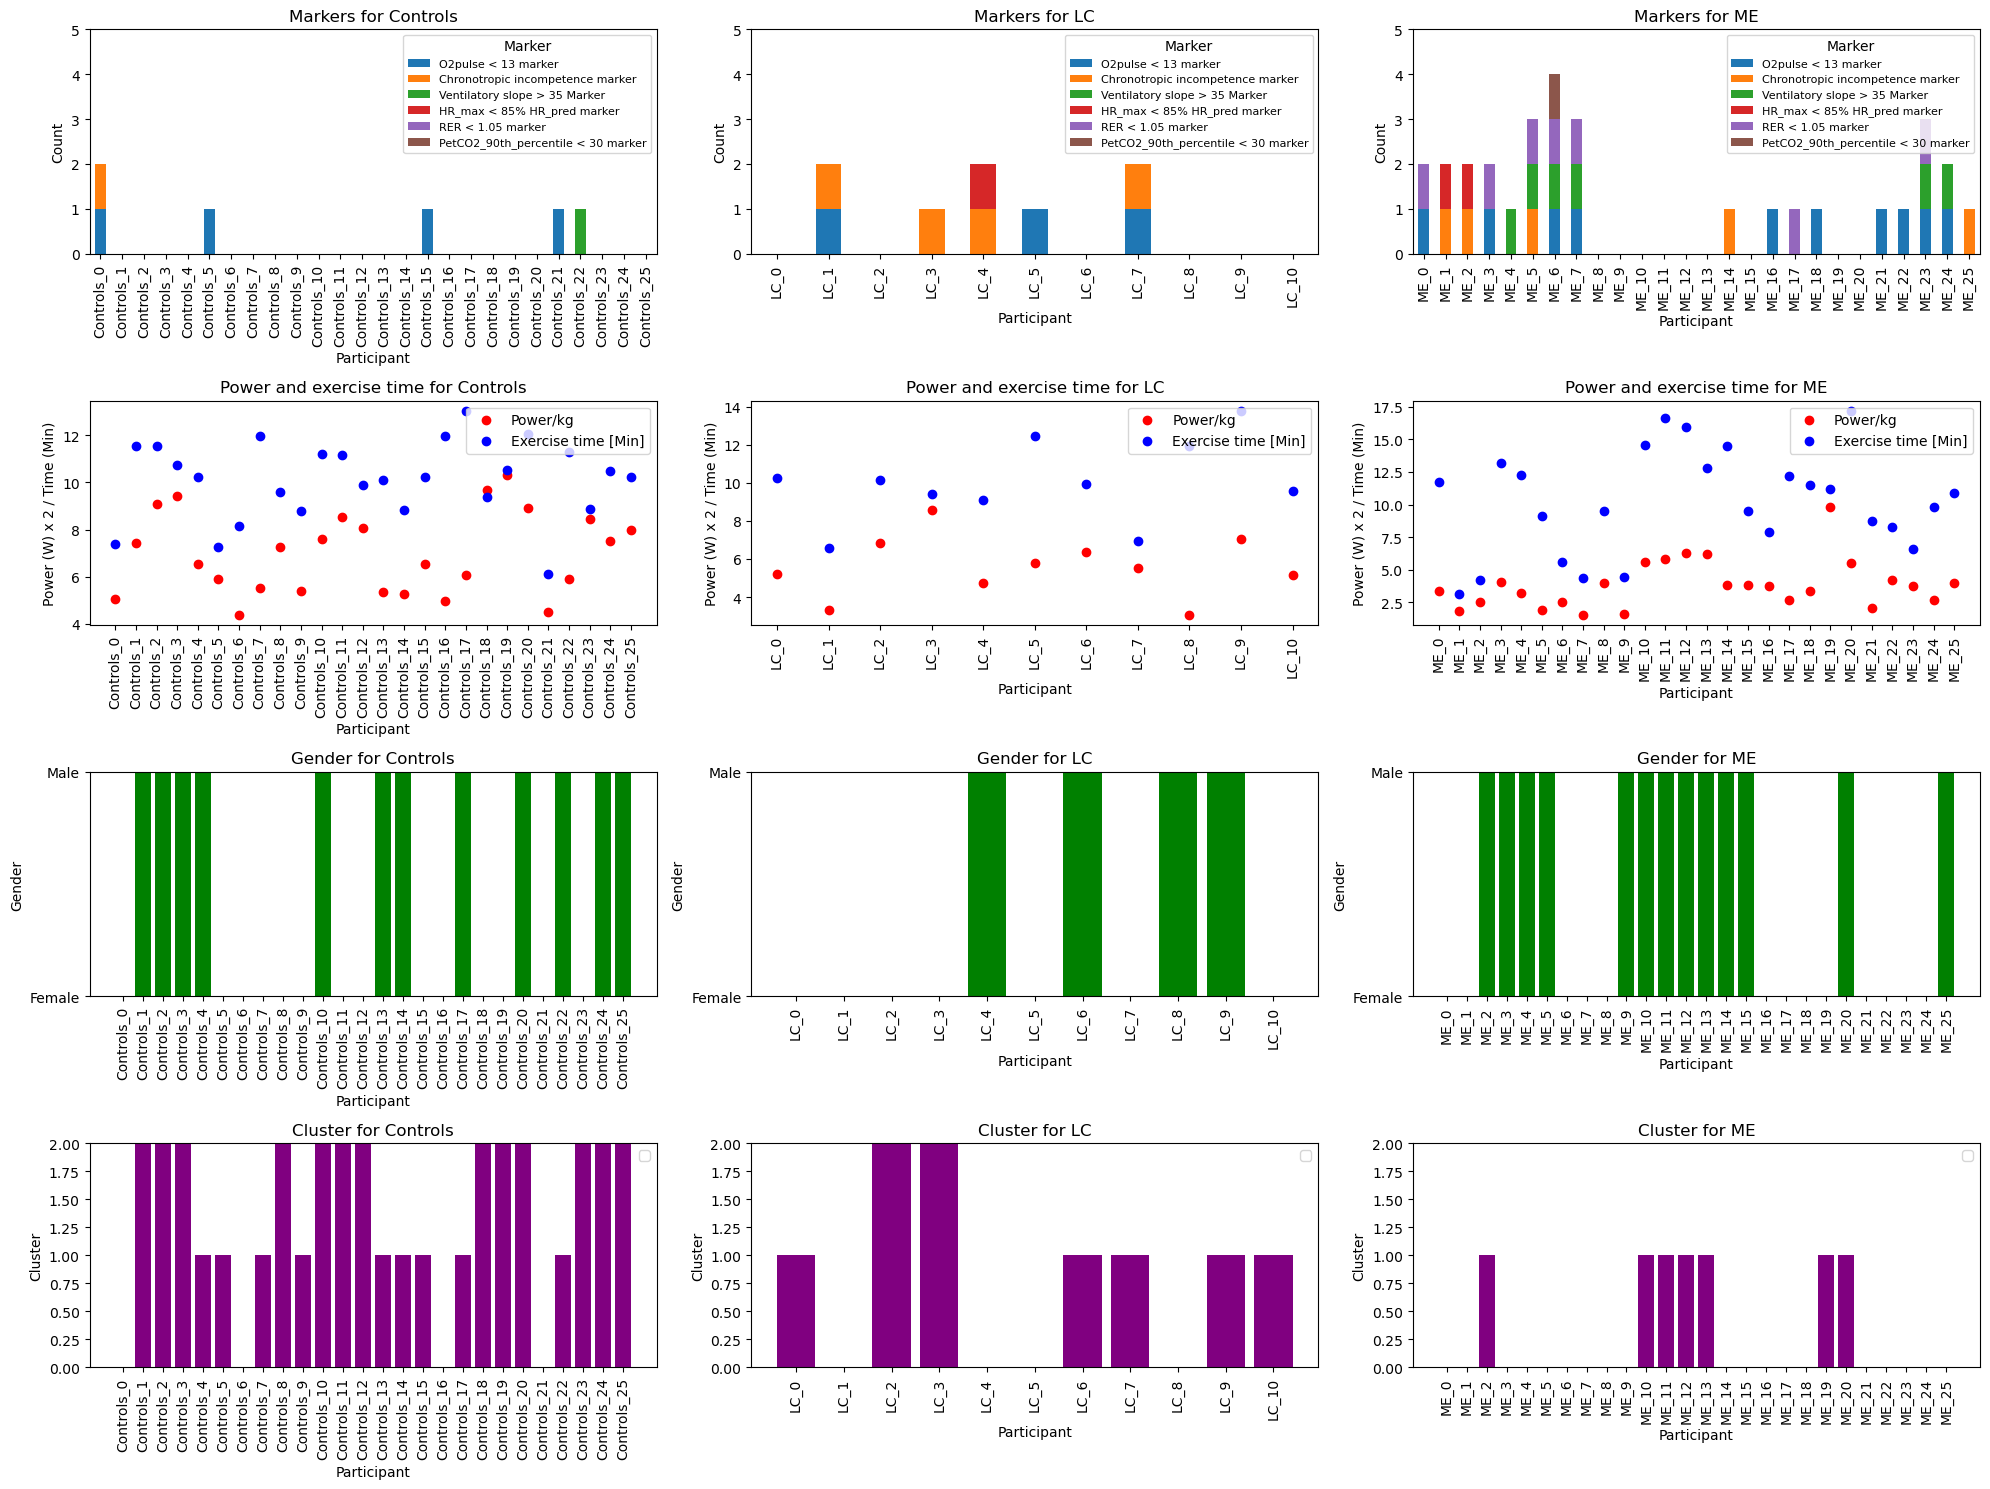

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
for i, summary in enumerate([[Mar_co, Co_sum], [Mar_LC, LC_sum], [Mar_ME, ME_sum]]):
    markers = summary[0].iloc[:, -(len(n_markers)+1):-2]
    markers = markers.astype(int)
    markers.plot(kind='bar', stacked=True, ax=ax[0, i])
    ax[0, i].set_title(f'Markers for {summary[0]["Group"].iloc[0]}')
    ax[0, i].set_xlabel('Participant')
    ax[0, i].set_ylabel('Count')
    ax[0, i].set_xticklabels(markers.index, rotation=90)
    ax[0, i].set_ylim(0, 5)
    # lock legend to top right corner, and make it smaller
    ax[0, i].legend(title='Marker', labels=markers.columns, loc='upper right', prop={'size': 8})

    ax[1, i].scatter(summary[1].index, summary[1]['Power/kg']*2, color='red', label='Power/kg')
    ax[1, i].scatter(summary[1].index, summary[1]['t_max'] / 60, color='blue', label='Exercise time [Min]')
    ax[1, i].set_title(f'Power and exercise time for {summary[0].index[0][:-2]}')
    ax[1, i].set_xlabel('Participant')
    ax[1, i].set_ylabel('Power (W) x 2 / Time (Min)')
    # rotate xticks
    ax[1, i].set_xticklabels(markers.index, rotation=90)
    # set the legend in the upper right corner
    ax[1, i].legend(loc='upper right')

    # the gender of each participant
    # map gender 0 to male, and 1 to female
    
    ax[2, i].bar(summary[1].index, summary[1]['Gender'].map({0:'Male', 1:'Female'}), color='green')
    ax[2, i].set_title(f'Gender for {summary[0].index[0][:-2]}')
    ax[2, i].set_xlabel('Participant')  
    ax[2, i].set_ylabel('Gender')
    ax[2, i].set_ylim(0, 1)
    ax[2, i].set_xticklabels(markers.index, rotation=90)


    # the cluster of each participant
    ax[3, i].bar(summary[1].index, summary[1]['Cluster'], color='purple')
    ax[3, i].set_title(f'Cluster for {summary[0].index[0][:-2]}')
    ax[3, i].set_xlabel('Participant')
    ax[3, i].set_ylabel('Cluster')
    ax[3, i].set_ylim(0, 2)
    ax[3, i].set_xticklabels(markers.index, rotation=90)
    ax[3, i].legend()

plt.tight_layout()
plt.show()


In [15]:
%%capture
# plot feature_list features for all of LC, LC_3, and all of Controls
# use df_exercise for the data
ven_parts = Markers_summary[Markers_summary['Ventilatory slope > 35 Marker']].index.tolist()
# drop all controls from ven_parts
ven_parts = [part for part in ven_parts if 'ME' in part]
target = ven_parts
feature_list = ['Ti', 'Te', 'HR', 'VO2', 'VE', 'VCO2', 'VT', 'Rf', 'RQ', 'PetCO2', 'PetO2', 'VE/VO2', 'VE/VCO2']
fig, ax = plt.subplots(len(feature_list),1, figsize=(10, 60))
for group, color in zip(['Controls', target, 'LC'], ['red', 'blue', 'green']):
    if group == target:
        df = df_exercise[df_exercise.index.isin(target)]
    else:
        df = df_exercise[(df_exercise['Group'] == group) & (~df_exercise.index.isin(target))]
    df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    for i, feature in enumerate(feature_list):
        if group == target:
            df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
            df_points = df.groupby('t')[feature].mean().rolling(window=10).mean()
            ax[i].plot(df_points, color=color, label=group)
        else:
            # take the mean of the feature for all participants in the group
            df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
            df_points = df.groupby('t')[feature].mean().rolling(window=10).mean()
            ax[i].plot(df_points, color=color, label=group)
        ax[i].set_title(feature)
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Feature value')
        ax[i].legend()
plt.tight_layout()
plt.show()

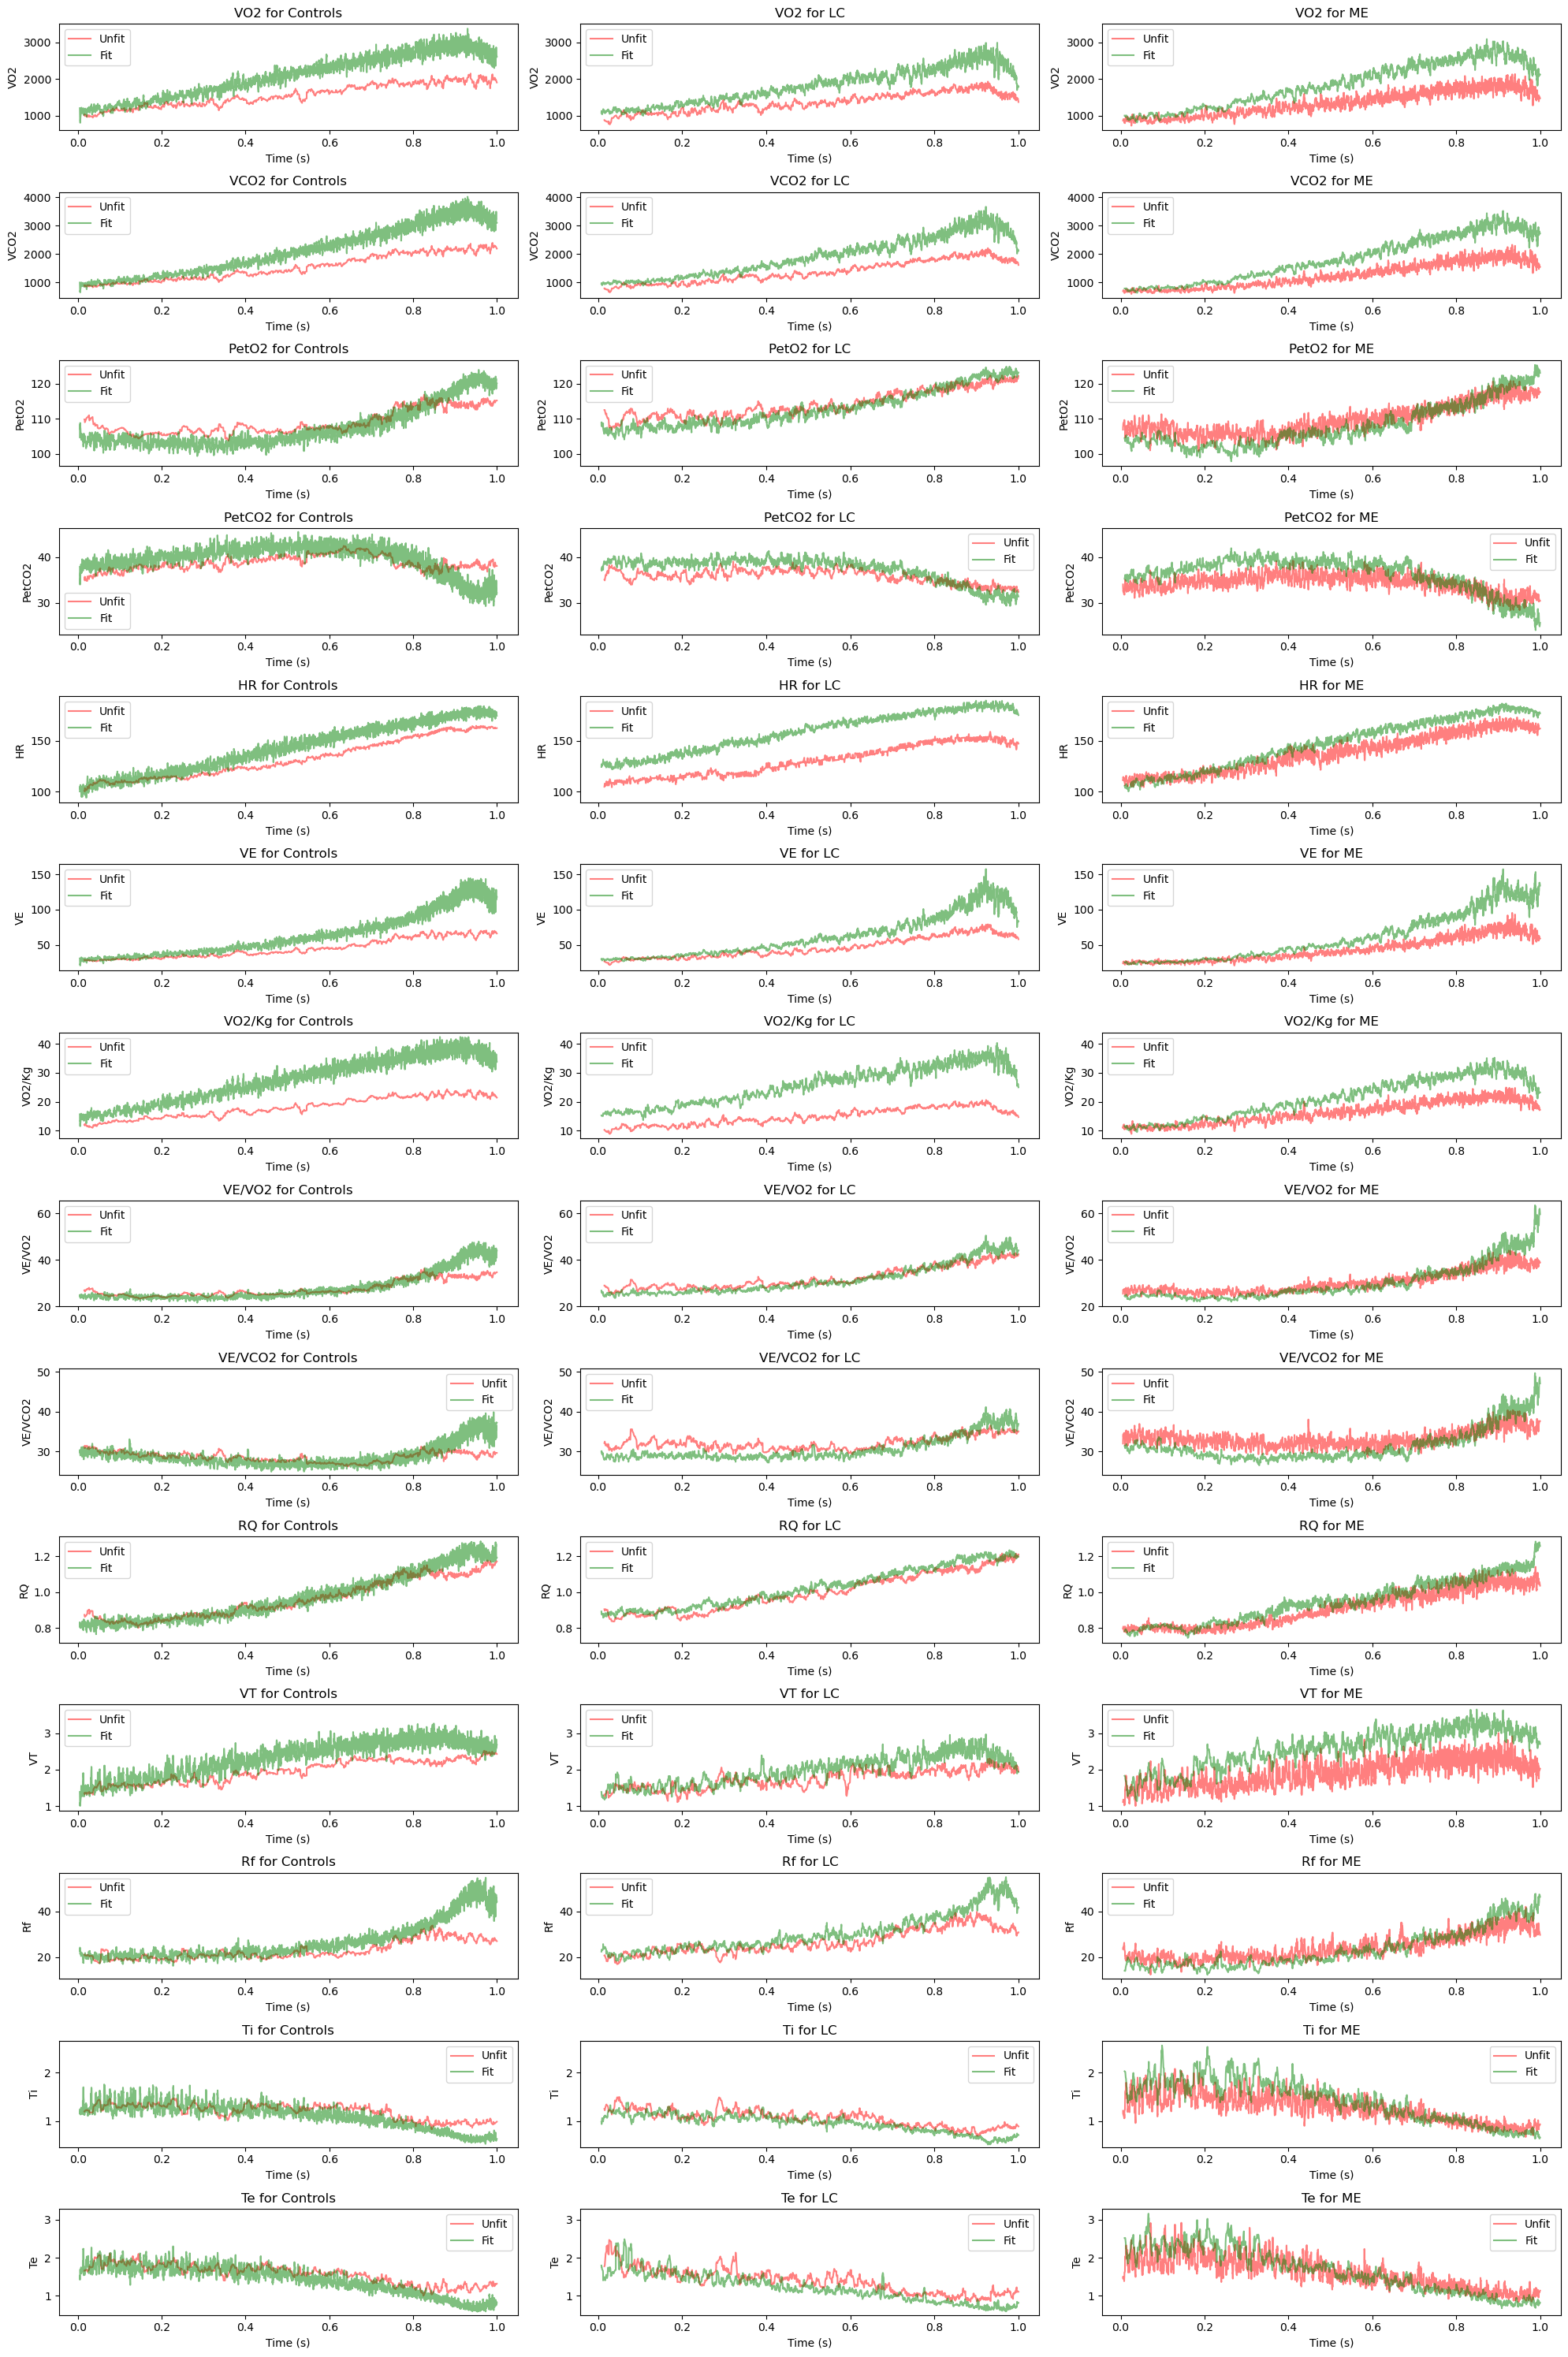

In [16]:
# concat Co_exercise, LC_exercise, ME_exercise
df_exercise = pd.concat([Co_exercise, LC_exercise, ME_exercise], axis=0)
df_exercise.set_index('Participant', inplace=True)
# map the fitness column to the df_exercise dataframe
df_exercise['Fitness'] = DF_summary['Fitness']
df_exercise['Group'] = DF_summary['Group']
# map group to their general group as opposed to the 50 or 100
df_exercise['Group'] = df_exercise['Group'].str[:2]
df_exercise.loc[df_exercise['Group'] == 'Co', 'Group'] = 'Controls'

# plot all the features per group and fitness level in a subplot, so each feature and group get a subplot, and both fitness levels are plotted in the same subplot

feature_list = ['VO2', 'VCO2', 'PetO2', 'PetCO2', 'HR', 'VE', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te']

# and make fit green and unfit red
fig, axs = plt.subplots(len(feature_list), 3, figsize=(20, 30))
for idx, feature in enumerate(feature_list):
    ylim = []
    for idx2, group in enumerate(df_exercise['Group'].unique()):
        for idx3, fitness in enumerate(df_exercise['Fitness'].unique()):
            # normalize time axis per participant and plot the mean of the feature over time
            df = df_exercise[(df_exercise['Group'] == group) & (df_exercise['Fitness'] == fitness)]
            t = copy.deepcopy(df['t'])
            df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
            df_points = df.groupby('t')[feature].mean().rolling(window=10).mean()
            axs[idx, idx2].plot(df_points, label=fitness, color=['red', 'green'][idx3], alpha=0.5)
            axs[idx, idx2].set_title(f'{feature} for {group}')
            axs[idx, idx2].set_xlabel('Time (s)')
            ylim.append(axs[idx, idx2].get_ylim())
            axs[idx, idx2].set_ylabel(feature)
            axs[idx, idx2].legend()
            # denormalize the time axis
            df['t'] = t
    # set the y limits to be the same for all subplots
    for idx2, ax in enumerate(axs[idx]):
        ax.set_ylim(min([i[0] for i in ylim]), max([i[1] for i in ylim]))
plt.tight_layout()
plt.show()



In [17]:
step_size = 700
p_values = []
features = ['VO2', 'VCO2', 'PetO2', 'PetCO2', 'HR', 'VE', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te']
df_equalized = {}
df_fit = df_exercise[df_exercise['Fitness'] == 'Fit']
df_unfit = df_exercise[df_exercise['Fitness'] == 'Unfit']
for df in [df_fit, df_unfit]:
    df_equal_group = []
    for group in df_exercise['Group'].unique():
        df_group = df[df['Group'] == group]
        df_equal = pd.DataFrame()
        t = copy.deepcopy(df['t'])
        df_group['t'] = df_group.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        for feature in features:
            df_points = df_group.groupby('t')[feature].mean()
            points = [0]
            for i in [x/step_size for x in range(1, step_size+1)]:
                points.append(df_points.index[df_points.index < i].tolist()[-1])
            df_points_mean = [df_points.loc[points[i]:points[i+1]].mean() for i in range(len(points)-1)]
            df_equal[feature] = df_points_mean
        df_equal['Group'] = group
        df_equal_group.append(df_equal)
        df['t'] = t
        df_equal.rename(columns={'VO2/Kg': 'VO2_Kg', 'VE/VO2': 'VE_VO2', 'VE/VCO2': 'VE_VCO2'}, inplace=True)
    df_equalized[df['Fitness'].iloc[0]] = pd.concat(df_equal_group, axis=0)
# reset index and name column time_bin
for key in df_equalized.keys():
    df_equalized[key].reset_index(inplace=True)
    df_equalized[key].rename(columns={'index': 'time_bin'}, inplace=True)


In [18]:
features = df_equalized['Fit'].columns[1:-1]
# ignore warnings

p_values_fitsplit = {}
for fitness_level, df in df_equalized.items():
    p_values = []
    for feature in features:
        df_practical = df[['time_bin', 'Group', feature]].copy()
        model = smf.mixedlm(f"{feature} ~ Group * time_bin", df_practical, groups=df_practical["Group"])
        result = model.fit()
        pvas = result.pvalues
        # compare LC and ME
        df_LC_ME = df_practical[df_practical['Group'].isin(['LC', 'ME'])]
        model = smf.mixedlm(f"{feature} ~ Group * time_bin", df_LC_ME, groups=df_LC_ME["Group"])
        result = model.fit()
        pvas['Intercept LC:ME'] = result.pvalues[1]
        pvas['Interaction LC:ME'] = result.pvalues[3]
        pvas.drop(['Intercept', 'time_bin', 'Group Var'], inplace=True)
        # rename to paper readable names, i.e. remove the Group[T.] part and replace it with intercept difference or interaction difference
        pvas.rename(index={'Group[T.LC]': 'Intercept Controls:LC', 'Group[T.ME]': 'Intercept Controls:ME', 'Group[T.LC]:time_bin': 'Interaction Controls:LC', 'Group[T.ME]:time_bin': 'Interaction Controls:ME'}, inplace=True)
        # reorder columns: first all intercepts, then all interactions
        pvas = pvas[['Intercept Controls:LC', 'Intercept Controls:ME', 'Intercept LC:ME', 'Interaction Controls:LC', 'Interaction Controls:ME', 'Interaction LC:ME']]
        
        reject, corrected_pvals, _, _ = multipletests(pvas, alpha=0.05, method='fdr_bh')
        corrected_pvals = [round(pval, 4) for pval in corrected_pvals]
        # add ** to corrected pvals that are smaller than 0.001 and * to corrected pvals that are smaller than 0.05
        corrected_pvals = [f'{pval}**' if pval < 0.01 else f'{pval}*' if pval < 0.05 else pval for pval in corrected_pvals]
        p_values.append(corrected_pvals)
    p_values_fitsplit[fitness_level] = pd.DataFrame(p_values, columns=pvas.index, index=features)
p_values_fitsplit['Fit']

# export the p_values to an excel file
with pd.ExcelWriter('p_values_fitsplit.xlsx') as writer:
    for key, df in p_values_fitsplit.items():
        df.to_excel(writer, sheet_name=key)



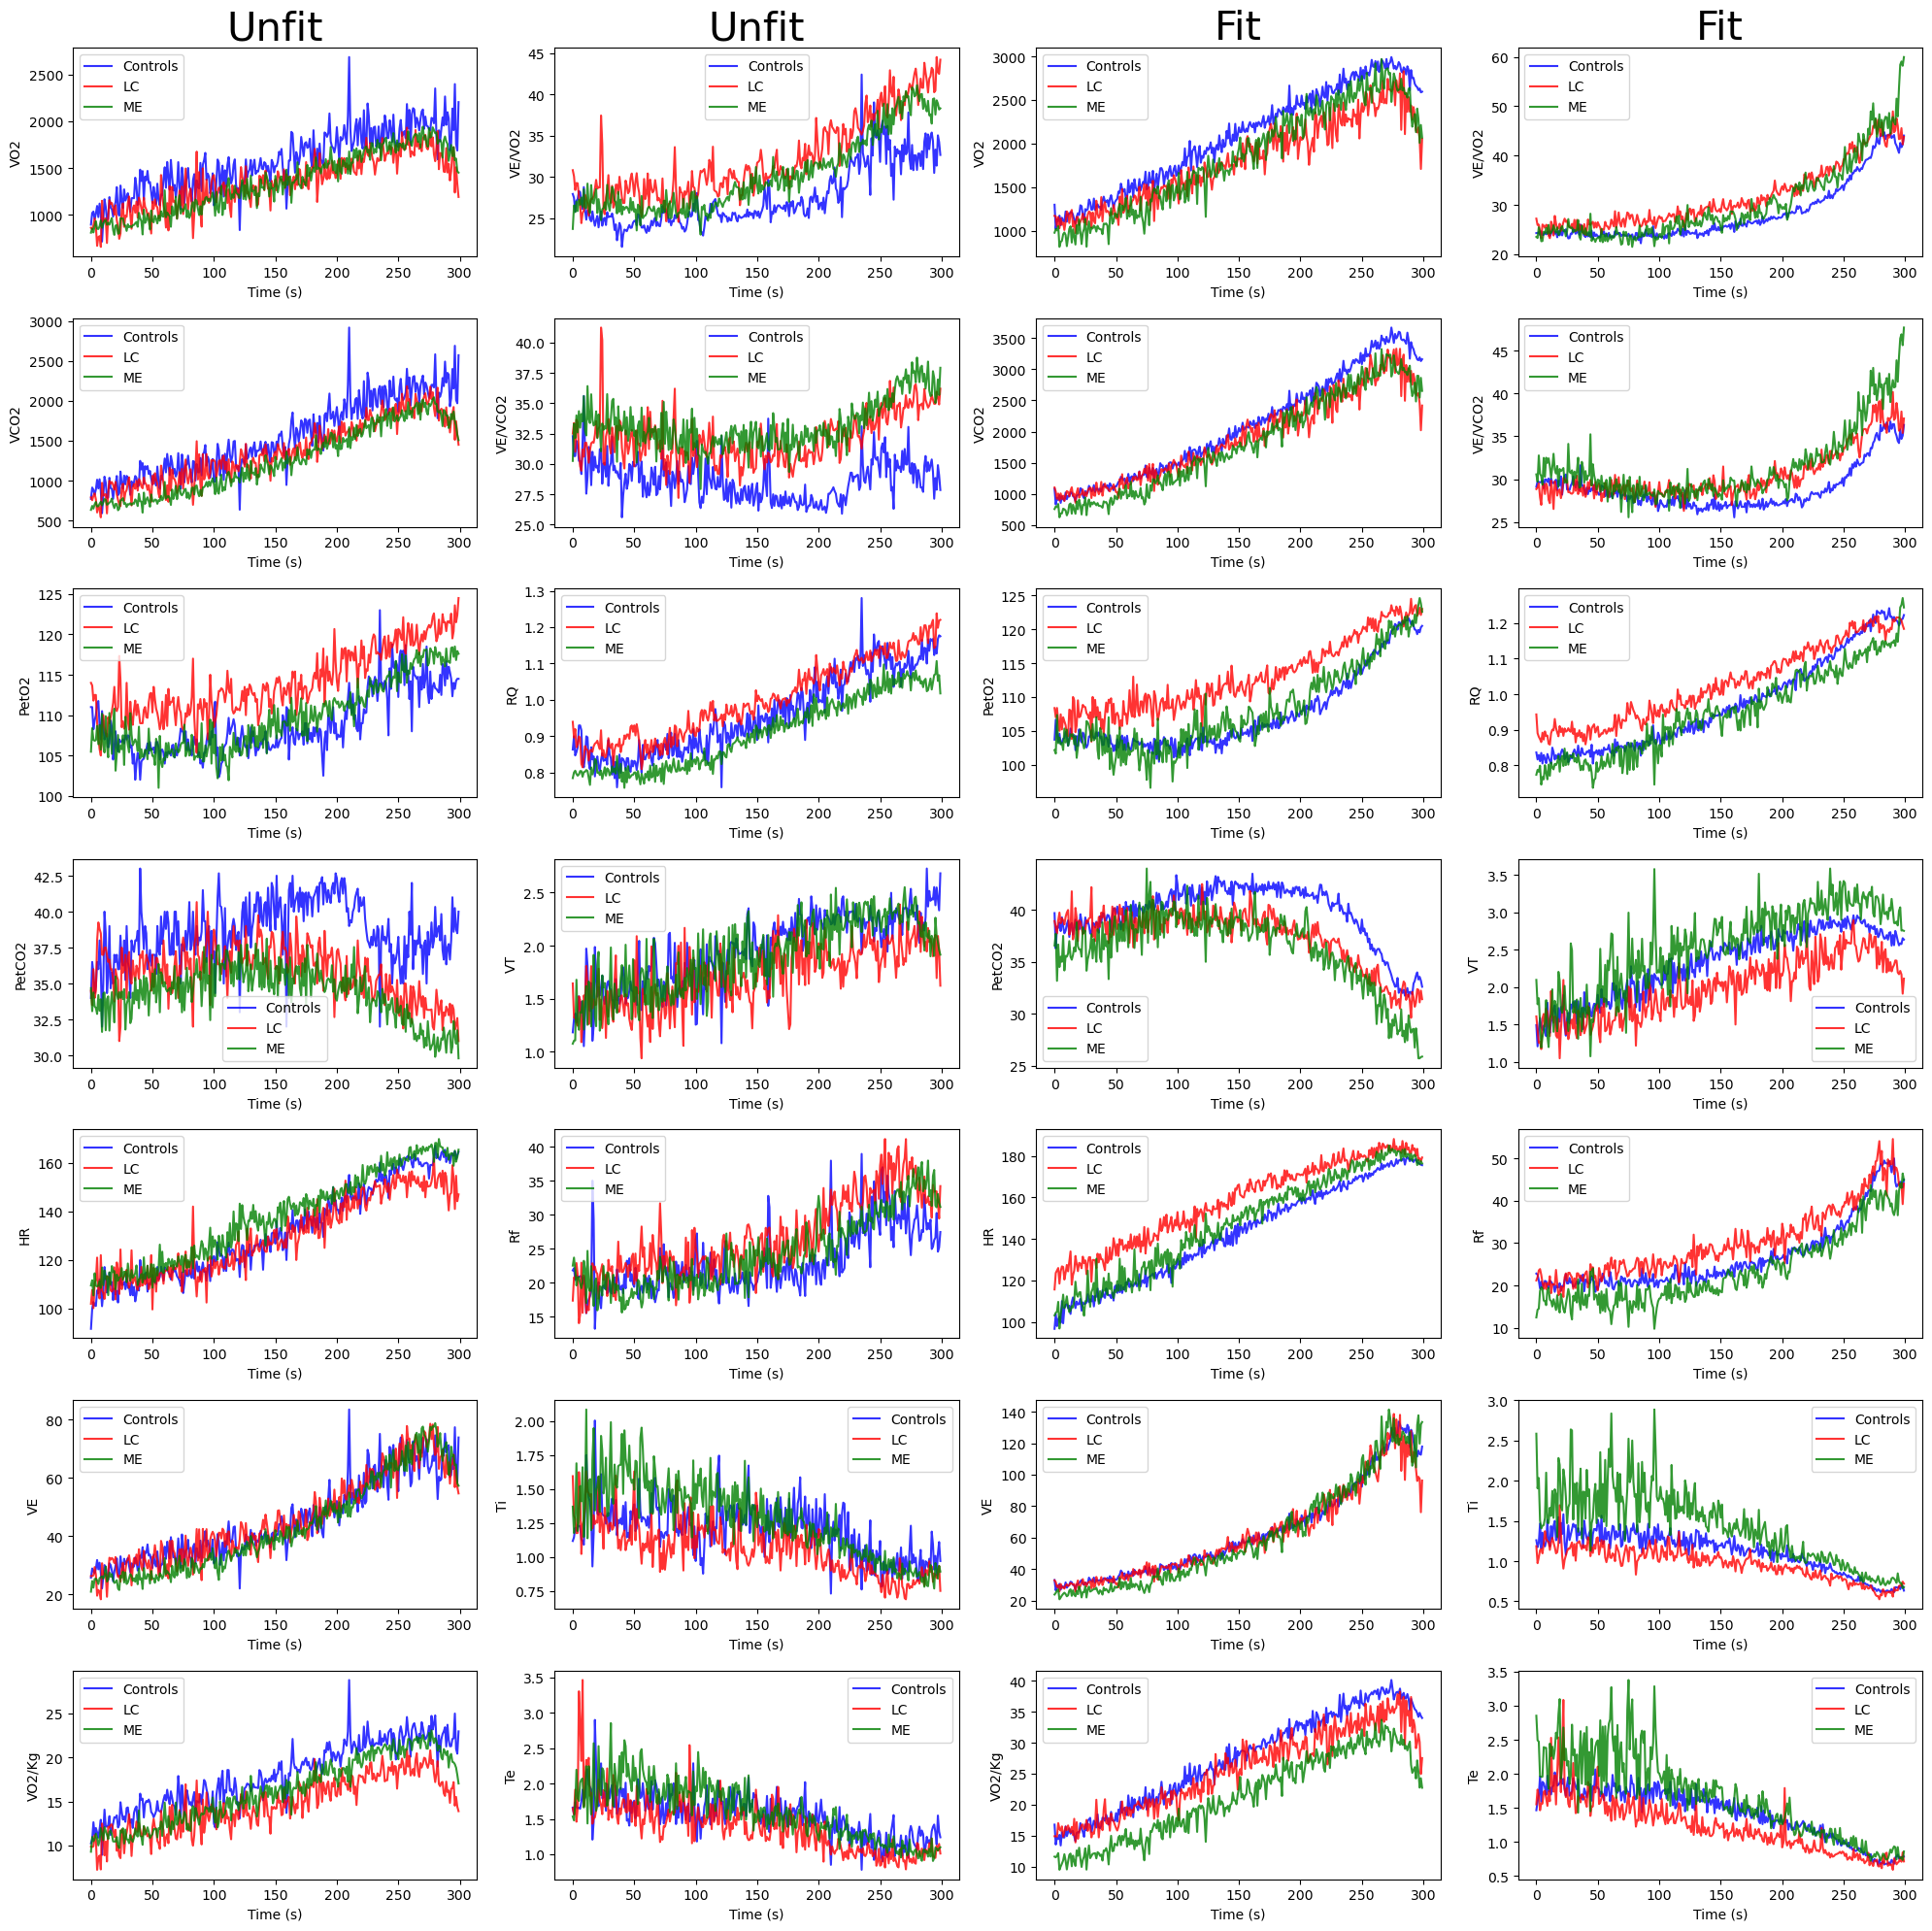

In [20]:
# make a similar plot to above, but now have ME, LC and Controls in one subplot, split by fitness level

fig, axs = plt.subplots(int(len(feature_list)/2), 4, figsize=(20, 20))
step_size = 300
for idx, feature in enumerate(feature_list):

    for idx2, fitness in enumerate(df_exercise['Fitness'].unique()):
        ylim = []
        for idx3, group in enumerate(df_exercise['Group'].unique()):
            # normalize time axis per participant and plot the mean of the feature over time
            df = df_exercise[(df_exercise['Group'] == group) & (df_exercise['Fitness'] == fitness)]
            t = copy.deepcopy(df['t'])
            df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
            df_points = df.groupby('t')[feature].mean()
            points = [0]
            for i in [x/step_size for x in range(1, step_size+1)]:
                points.append(df_points.index[df_points.index < i].tolist()[-1])
            df_points_mean = [df_points.loc[points[i]:points[i+1]].mean() for i in range(len(points)-1)]

            if idx2 == 0:
                col = 0
            else:
                col = 2
            if idx < len(feature_list)/2:
                row = idx
            else:
                col += 1
                row = idx - int(len(feature_list)/2)
            axs[row, col].plot(df_points_mean, label=group, color=['blue', 'red', 'green'][idx3], alpha=0.8)
            axs[row, col].set_xlabel('Time (s)')
            ylim.append(axs[row, col].get_ylim())
            axs[row, col].set_ylabel(feature)
            # increase the size of the labels
            axs[row, col].legend(prop={'size': 10})
            # denormalize the time axis
            df['t'] = t
        # set the y limits per subplot as the max and min of the y limits of the subplot
        axs[row, col].set_ylim(min([i[0] for i in ylim]), max([i[1] for i in ylim]))
# set title of the first two columns to be Fit, and the last two to be Unfit
for ax, col in zip(axs[0], ['Unfit','Unfit','Fit', 'Fit']):
    ax.set_title(col, fontsize=30)
plt.tight_layout()
plt.show()

In [21]:

y = df_exercise['Group'].map({'Controls': 0, 'LC': 1, 'ME': 2})

classes = np.array([0, 1, 2])  # Assign numerical labels to classes

class_weights = compute_class_weight("balanced", classes = classes, y = y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)



Class weights: {0: 0.7790302107133791, 1: 1.7059150544807649, 2: 0.8848327566320646}


In [39]:
# set the seed for reproducibility
np.random.seed(42)

def score_model(df_random_train, df_random_test, df_exercise, params, fraction_data_used, save_tree=False, save_confusion=False, save_fi=False, save_statistics=False, n_count=0, dropped_cols = []):
    #for i in range(1,5):
    #print(i*0.25)
    # create a new dataframe with the first 25% of each participant's data
    if fraction_data_used == 1:
        DF_25 = df_random_train
        DF_25_test = df_random_test
    elif fraction_data_used < 1:
        DF_25 = pd.DataFrame()
        DF_25_test = pd.DataFrame()
        for participant in df_random_train.index.unique():
            DF_25 = pd.concat([DF_25, df_random_train.loc[participant].iloc[:int(fraction_data_used * len(df_random_train.loc[participant]))]], axis=0)
        for participant in df_random_test.index.unique():
            DF_25_test = pd.concat([DF_25_test, df_random_test.loc[participant].iloc[:int(fraction_data_used * len(df_random_test.loc[participant]))]], axis=0)
    
    #Shuffle the rows of DF_25 to avoid bias
    DF_25 = DF_25.sample(frac=1)
    DF_25_test = DF_25_test.sample(frac=1)

    # split the data into features and target
    X_train = DF_25.drop(columns=dropped_cols + ['Group', 'Fitness'])
    X_test = DF_25_test.drop(columns=dropped_cols + ['Group', 'Fitness'])
    y_train = DF_25['Group'].map({'Controls': 0, 'LC': 1-n_count, 'ME': 2-n_count})
    y_test = DF_25_test['Group'].map({'Controls': 0, 'LC': 1-n_count, 'ME': 2-n_count})

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # create lgmb classifier but minimize overfitting
    modela = LGBMClassifier(**params)

    modela.fit(X_train_scaled, y_train)
    # save the feature importance to visualize it later
    if save_fi:
            feature_importance = modela.feature_importances_
            feature_importance = {feature: importance for feature, importance in zip(X_train.columns, feature_importance)}
            feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    else:
            feature_importance = None

    # save the tree to visualize it later      
    if save_tree:
            st = SuperTree(modela, 
            X_train_scaled,
            y_train, #feature names
            list(X_train.columns), #class names
            ['Controls', 'LC', 'ME'])
    else:
            st = None

    # save the confusion matrices to visualize them later
    if save_confusion:
            y_pred = modela.predict(X_test_scaled)
            confusion = confusion_matrix(y_test, y_pred)
    else:
            confusion = None

    if save_statistics:
            # save the statistics to visualize them later
            X = df_exercise.drop(columns= dropped_cols + ['Group', 'Fitness'])
            X_scaled = scaler.fit_transform(X)
            X.reset_index(inplace=True)
            y_pred = modela.predict(X_scaled)
            y_pred = pd.DataFrame(y_pred)
            y_pred.columns = ['Group']
            y_pred['Group'] =  y_pred['Group'].map({0: 'Controls', 1: 'LC', 2: 'ME'})
            stats_guesses = pd.DataFrame()
            stats_guesses['Participant'] = df_exercise.index.unique()
            stats_guesses['train_or_test'] = 0
            stats_guesses['Correct'] = 0
            stats_guesses['Controls'] = 0
            stats_guesses['LC'] = 0
            stats_guesses['ME'] = 0
            for participant in df_exercise.index.unique():
                    orig = participant.split('_')[0]
                    indexes = X[X['Participant'] == participant].index
                    counts = y_pred.loc[indexes].value_counts()
                    if orig in counts:
                            stats_guesses.loc[stats_guesses['Participant'] == participant, 'Correct'] = np.round(counts[orig] / counts.sum(),2)
                    else:
                            stats_guesses.loc[stats_guesses['Participant'] == participant, 'Correct'] = 0
                    if participant in df_random_train.index.unique():
                            stats_guesses.loc[stats_guesses['Participant'] == participant, 'train_or_test'] = 'TRAIN'
                    elif participant in df_random_test.index.unique():
                            stats_guesses.loc[stats_guesses['Participant'] == participant, 'train_or_test'] = 'VAL'

                    for groupname in ['Controls', 'LC', 'ME']:
                            if groupname in counts:
                                    stats_guesses.loc[stats_guesses['Participant'] == participant, groupname] = counts[groupname]
                            else:
                                    stats_guesses.loc[stats_guesses['Participant'] == participant, groupname] = 0
    else:
            stats_guesses = None

    # calculate the scores for each group
    # procedurally generate scores_round dictionary based on what groups are in the dataframe
    scores_round = {}
    scores_round['all'] = modela.score(X_test_scaled, y_test)
    for group in df_exercise['Group'].unique():
        X_group = X_test[X_test.index.str.contains(group)]
        y_group = y_test[y_test.index.str.contains(group)]
        X_group_scaled = scaler.transform(X_group)
        scores_round[group] = modela.score(X_group_scaled, y_group)

    return scores_round, confusion, feature_importance, st, stats_guesses

def create_individual(df_exercise, random='Random', test_size: list = [18, 3, 18], num_groups = 3):
    # extract participant identifiers either from the index or a "Participant" column
    if df_exercise.index.name == 'Participant':
        participants = df_exercise.index.unique()
        use_index = True
    elif 'Participant' in df_exercise.columns:
        participants = df_exercise['Participant'].unique()
        use_index = False
    else:
        participants = df_exercise.index.unique()
        use_index = True
    if type(random) == str:
        random = random.upper()
    if random == 'RANDOM':
        if num_groups == 3:
            co_part = np.random.choice(participants[participants.str.contains('Controls')], test_size[0], replace=False)
            lc_part = np.random.choice(participants[participants.str.contains('LC')], test_size[1], replace=False)
            me_part = np.random.choice(participants[participants.str.contains('ME')], test_size[2], replace=False)
        elif num_groups != 3:
            groups = df_exercise['Group'].unique()
            for group in groups:
                if group == 'Controls':
                    co_part = np.random.choice(participants[participants.str.contains('Controls')], test_size[0], replace=False)
                elif group == 'LC':
                    lc_part = np.random.choice(participants[participants.str.contains('LC')], test_size[1], replace=False)
                elif group == 'ME':
                    me_part = np.random.choice(participants[participants.str.contains('ME')], test_size[2], replace=False)
    # if random is type string, raise an error
    elif type(random) == str:
        raise ValueError("Random must be either 'Random' or a list of participants")
    # if random is a list of participants, use those participants
    else:
        if num_groups == 3:
            co_part = random[0]
            lc_part = random[1]
            me_part = random[2]
        elif num_groups != 3:
            groups = df_exercise['Group'].unique()
            for group in groups:
                if group == 'Controls':
                    co_part = random[0]
                elif group == 'LC' and 'Controls' in groups:
                    lc_part = random[1]
                elif group == 'LC':
                    lc_part = random[0]
                elif group == 'ME' and 'Controls' in groups and 'LC' in groups:
                    me_part = random[2]
                elif group == 'ME' and 'Controls' in groups:
                    me_part = random[1]
                elif group == 'ME':
                    me_part = random[0]

    # concatenate the participants for selection, then sort by groups
    if num_groups == 3:
        selected_participants = np.concatenate([co_part, lc_part, me_part])
        participant_list = [co_part, lc_part, me_part]
    elif num_groups != 3:
        selected_participants = np.array([])
        for group in groups:
            if group == 'Controls':
                selected_participants = np.concatenate([selected_participants, co_part])
            elif group == 'LC':
                selected_participants = np.concatenate([selected_participants, lc_part])
            elif group == 'ME':
                selected_participants = np.concatenate([selected_participants, me_part])
        participant_list = []
        for group in groups:
            if group == 'Controls':
                participant_list.append(co_part)
            elif group == 'LC':
                participant_list.append(lc_part)
            elif group == 'ME':
                participant_list.append(me_part)
        
    # select the test and training data based on the participant identifiers.
    if use_index:
        df_random_test = df_exercise[df_exercise.index.isin(selected_participants)]
        df_random_train = df_exercise[~df_exercise.index.isin(selected_participants)]
    else:
        df_random_test = df_exercise[df_exercise['Participant'].isin(selected_participants)]
        df_random_train = df_exercise[~df_exercise['Participant'].isin(selected_participants)]
    
    return (df_random_train, df_random_test, participant_list)


def create_mating_pool(pop, n_pop, reward = 'individual', target = None, flattener=0.1, direction = 'max'):
    reward = reward.upper()
    direction = direction.upper()
    mating_pool = []
    if reward == 'INDIVIDUAL':
        for idx, group in enumerate(list(pop[1][1].keys())[1:]):
            scores = {}
            for par in pop:
                scores[par[2]] = par[1][group]
                # sort values and give each individual a rank based on their score
            if direction == 'MAX':
                    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            elif direction == 'MIN':
                    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=False)
            else: # give an error if the direction is not max or min
                raise ValueError("Direction must be either 'max' or 'min'")
            sorted_scores = {k: v for k, v in sorted_scores}
            rank = 1
            total_prob_factor = 1/sum([1/(rank+flattener) for rank in range(1, len(sorted_scores)+1)])
            for key in sorted_scores:
                sorted_scores[key] = total_prob_factor *(1/(rank+flattener))
                rank += 1

            # pick n_pop/2 individuals based on their probability
            selected = np.random.choice(list(sorted_scores.keys()), round(n_pop/2), p=list(sorted_scores.values()))
            # turn the selected individuals into a list of participants, allowing for duplicate individuals to be selected
            selected = [pop[i][0][idx] for i in range(len(pop)) for select in selected if pop[i][2] == select]
            mating_pool.append(selected)

    elif reward == 'GROUP':
            scores = {}
            # selection pressure is based on the mean score of the individual across all groups
            if target == None:
                for par in pop:
                    scores[par[2]] = np.mean(list(par[1].values())[1:])
            # selection pressure is based on the score of the target group and the mean score of all groups
            elif target in ['Controls', 'LC', 'ME']:
                for par in pop:
                    scores[par[2]] = par[1][target]*0.3 + np.mean(list(par[1].values()))*0.7
            else:
                raise ValueError("Target must be either 'Controls', 'LC', 'ME' or None")

            # sort values and give each individual a rank based on their score
            if direction == 'MAX':
                sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            elif direction == 'MIN':
                sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=False)
            sorted_scores = {k: v for k, v in sorted_scores}
            rank = 1
            total_prob_factor = 1/sum([1/(rank+flattener) for rank in range(1, len(sorted_scores)+1)])
            for key in sorted_scores:
                sorted_scores[key] = total_prob_factor *(1/(rank+flattener))
                rank += 1

            # pick n_pop/2 individuals based on their probability
            selected = np.random.choice(list(sorted_scores.keys()), round(n_pop/2), p=list(sorted_scores.values()))
            # turn the selected individuals into a list of participants, allowing for duplicate individuals to be selected
            mating_pool = [[pop[i][0][j] for i in range(len(pop)) for select in selected if pop[i][2] == select] for j in range(len(list(pop[1][1].keys())[1:]))]      

             
    else:
        raise ValueError("Reward must be either 'individual' or 'group'")
    return mating_pool

def retrieve_df(indi_participants, df_exercise):

    participants = np.concatenate([indi_participants[i] for i in range(len(indi_participants))])
    # Check if 'Participant' is the index name
    if df_exercise.index.name == 'Participant':
        df_random_test = df_exercise.loc[participants]
        df_random_train = df_exercise.drop(index=participants)
    # Otherwise, check if 'Participant' is a column in the DataFrame
    elif 'Participant' in df_exercise.columns:
        df_random_test = df_exercise[df_exercise['Participant'].isin(participants)]
        df_random_train = df_exercise[~df_exercise['Participant'].isin(participants)]
    else:
        # Fallback: assume participants are in the index
        df_random_test = df_exercise.loc[participants]
        df_random_train = df_exercise.drop(index=participants)
    return (df_random_train, df_random_test, indi_participants)

def recombinator(mating_pool, fraction_data_used, df_exercise, n_pop, k, params, n_count, dropped_cols, mutation_rate=0.3):
    new_pop = []
    for _ in range(n_pop):
        indi = []
        for idx, group in enumerate(list(df_exercise['Group'].unique())):
            mating_pool_group = mating_pool[idx]
            # create new individuals by recombination of participants
            indi_cat = []

            # randomly select two participants from the mating pool
            parent_int = np.random.choice(range(len(mating_pool_group)), 2, replace=False)
            parent_1 = mating_pool_group[parent_int[0]]
            parent_2 = mating_pool_group[parent_int[1]]
            # 20% chance to keep parent 1 as is, 20% chance to keep parent 2 as is, 60% chance to combine the two
            prob = np.random.rand()
            if prob < 0.2:
                indi_cat = parent_1
            elif prob < 0.4:
                indi_cat = parent_2
            else:
                combined = list(set(np.concatenate([parent_1, parent_2])))
                # pick n integers between 0 and len(combined) without replacement
                try:
                    combin = np.random.choice(range(len(combined)), len(parent_1), replace=False)
                except ValueError: # return combined and terminate the function
                    return 1, [combined, parent_1, parent_2, indi_cat]
                    
                indi_cat = np.array([combined[i] for i in combin])
            
            # mutation: 30% chance to change one participant to a random participant not in the group
            prob = np.random.rand()
            if len(indi_cat) != len(set(indi_cat)):
                print('Duplicate early')
                return 1, [indi_cat, parent_1, parent_2, indi_cat]
            if prob < mutation_rate:
                participants = df_exercise.index.unique()[df_exercise.index.unique().str.contains(group)]
                # find the participant that are not currently in the individual
                participants = participants[participants.isin(indi_cat) == False]
                new_part = np.random.choice(participants)
                indi_cat = indi_cat.astype(object)
                indi_cat[np.random.randint(0, len(indi_cat))] = new_part
            # if indicat contains duplicates, return 1 and the individual
            if len(indi_cat) != len(set(indi_cat)):
                print('Duplicate error')
                return 1, [indi_cat, parent_1, parent_2, indi_cat]
            indi.append(indi_cat)
        # combine the 3 groups into a single group of individuals
        # add the appropriate dataframes to the individual
        indi = retrieve_df(indi, df_exercise)
        score = score_model(indi[0], indi[1], df_exercise, params = params, fraction_data_used = fraction_data_used, n_count=n_count, dropped_cols=dropped_cols)[0]
        name = f'Individual {k}'
        k += 1
        new_pop.append([indi[2], score, name])
    return new_pop, k


# Reporting function that reports the best individual of each generation per group and the best individual overall
# best individual overall is the individual with the highest mean score across the groups
# write the best scores and the respective participants of that individual (i.e. 'ME_23', 'LC_5') to a csv file that gets updated each generation
def report(pop, n_gen, direction, savefile=None, save=True):
    direction = direction.upper()
    best_individuals = {}
    best_individuals['Overall'] = [None, None, '']
    for group in list(pop[0][1].keys())[1:]:
        best_individuals[group] = [None, None, '']
    for individual in pop:
        if direction == 'MAX':
            if best_individuals['Overall'][1] is None or np.mean(list(individual[1].values())) > best_individuals['Overall'][1]:
                best_individuals['Overall'] = [individual[0], np.mean(list(individual[1].values())), individual[2]]
            for group in list(pop[0][1].keys())[1:]:
                if best_individuals[group][1] is None or individual[1][group] > best_individuals[group][1]:
                    best_individuals[group] = [individual[0], individual[1][group], individual[2]]
        elif direction == 'MIN':
            if best_individuals['Overall'][1] is None or np.mean(list(individual[1].values())) < best_individuals['Overall'][1]:
                best_individuals['Overall'] = [individual[0], np.mean(list(individual[1].values())), individual[2]]
            for group in list(pop[0][1].keys())[1:]:
                if best_individuals[group][1] is None or individual[1][group] < best_individuals[group][1]:
                    best_individuals[group] = [individual[0], individual[1][group], individual[2]]
    
    # Global memory for best values across generations
    global global_best
    if n_gen == 0:
        global_best = {key: best_individuals[key] for key in best_individuals}
    else:
        for key in best_individuals:
            if direction == 'MAX':
                if best_individuals[key][1] is not None and best_individuals[key][1] > global_best[key][1]:
                    global_best[key] = best_individuals[key]
            elif direction == 'MIN':
                if best_individuals[key][1] is not None and best_individuals[key][1] < global_best[key][1]:
                    global_best[key] = best_individuals[key]

    if save:
        with open(savefile, 'a') as f:
            f.write(f'Generation {n_gen}\n')
            for group in best_individuals:
                f.write(f'{group}: {best_individuals[group][2]} with score {best_individuals[group][1]}\n')
                f.write(f'Participants: {[sorted(best_individuals[group][0][i].tolist(), key=lambda x: int(x.split("_")[1])) for i in range(len(best_individuals[group][0]))]}\n')
            f.write('Global best so far:\n')
            for group in global_best:
                f.write(f'{group}: {global_best[group][2]} with score {global_best[group][1]}\n')
            f.write('\n')
    print(f'Generation {n_gen}')
    for group in best_individuals:
        print(f'{group}: {best_individuals[group][2]} with score {best_individuals[group][1]}')
    print("Global best so far:")
    for group in global_best:
        print(f'{group}: {global_best[group][2]} with score {global_best[group][1]}')
    return best_individuals


def create_init_pop(df_exercise, n_pop, params, fraction_data_used = 1, test_size = [18, 3, 18], num_groups = 3, n_count=0, dropped_cols = []):
    pop = []
    for k in range(n_pop):
        indi = create_individual(df_exercise, test_size=test_size, num_groups=num_groups)
        score = score_model(indi[0], indi[1], df_exercise, params = params, fraction_data_used = fraction_data_used, n_count=n_count, dropped_cols=dropped_cols)[0]
        name = f'Individual {k}'
        pop.append([indi[2], score, name])
    return pop, k

# Ensure the dataframe uses the participant identifiers as its index.
#if 'Participant' in df_exercise.columns:
#    df_input = df_exercise[df_exercise['Group'] != 'ME'].set_index('Participant')
#else:
#    df_input = df_exercise[df_exercise['Group'] != 'ME']
df_input = df_exercise.copy()
#DF_ME_placeholder = df_input[df_input.index.str.contains('LC')]
#DF_ME_placeholder = DF_ME_placeholder[DF_ME_placeholder.index.str.endswith(('2', '3', '6', '8', '9'))]
#DF_ME_placeholder.index = DF_ME_placeholder.index.str.replace('LC', 'ME')
#DF_ME_placeholder['Group'] = 'ME'
#df_input = df_input[~(df_input.index.str.endswith(('2', '3', '6', '8', '9')) & df_input.index.str.contains('LC'))]
#df_input = pd.concat([df_input, DF_ME_placeholder], axis=0)

n_pop = 20
n_gen = 10
flattener = 1.5
reward = 'GROUP'
direction = 'MIN'
test_size = [4,4,4]
fraction_data_used = 0.25
dropped_cols = ['t', 'Power', 'HR', 'VO2', 'VO2/Kg']
#df_input = df_exercise[df_exercise['Group'] != 'ME']
n_count = 0
if 'Controls' not in df_input['Group'].unique():
    n_count += 1
if 'LC' not in df_input['Group'].unique():
    n_count += 1
y = df_input['Group'].map({'Controls': 0, 'LC': 1-n_count, 'ME': 2-n_count})
if 'ME' not in df_input['Group'].unique():
    n_count += 1
classes = np.unique(np.array([0, 1-n_count, 2-n_count]))  # Assign numerical labels to classes
class_weights = compute_class_weight("balanced", classes = classes, y = y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
if 'ME' not in df_input['Group'].unique():
    n_count -= 1
num_groups = df_input['Group'].nunique()
print('Groupsize:', num_groups)
print("Class weights:", class_weights_dict)

param = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": num_groups,  # Number of classes
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "class_weight": class_weights_dict,  # Apply class weights
    "verbosity": -1,
}
target = None
savefile = f'{direction}_{reward}_{int(fraction_data_used*100)}.csv'
test = False

try:
    del global_best
except NameError:
    pass

# create the file for the best individuals
if test == False:
    with open(savefile, 'w') as f:
        f.write('Best individuals\n')
else:
    n_gen = 1

# create a population of random participants
pop, k = create_init_pop(df_input, n_pop, params=param, fraction_data_used=fraction_data_used, test_size=test_size, num_groups=num_groups, n_count=n_count, dropped_cols=dropped_cols)
# print hyperparameters
print(f'Population size: {n_pop}')
print(f'Number of generations: {n_gen}')
print(f'Reward: {reward}')
print(f'Direction: {direction}')
print(f'Fraction of data used: {fraction_data_used}')
print('')
for gen in range(n_gen):
    mating_pool = create_mating_pool(pop, n_pop, reward, target, flattener, direction)
    # if recombinator outputs a single output as opposed to 3, it means that something went wrong and the function should be terminated
    new_pop, k = recombinator(mating_pool, fraction_data_used, df_input, n_pop, k, param, n_count, dropped_cols)
    if new_pop == 1:
        print('Recombinator failed')
        break
    pop = new_pop
    if test == False:
        report(pop, gen, direction, savefile)
    print(f'Generation {gen} done')
    print('')

Groupsize: 3
Class weights: {0: 0.7790302107133791, 1: 1.7059150544807649, 2: 0.8848327566320646}
Population size: 20
Number of generations: 10
Reward: GROUP
Direction: MIN
Fraction of data used: 0.25

Generation 0
Overall: Individual 27 with score 0.34138367562495997
Controls: Individual 27 with score 0.3018867924528302
LC: Individual 27 with score 0.23552123552123552
ME: Individual 22 with score 0.22413793103448276
Global best so far:
Overall: Individual 27 with score 0.34138367562495997
Controls: Individual 27 with score 0.3018867924528302
LC: Individual 27 with score 0.23552123552123552
ME: Individual 22 with score 0.22413793103448276
Generation 0 done

Generation 1
Overall: Individual 56 with score 0.34946603257411607
Controls: Individual 46 with score 0.3120567375886525
LC: Individual 58 with score 0.1423487544483986
ME: Individual 56 with score 0.3848797250859107
Global best so far:
Overall: Individual 27 with score 0.34138367562495997
Controls: Individual 27 with score 0.301886

In [23]:

LC_subset = ['LC_7', 'LC_4', 'LC_2', 'LC_8']
# sample 19 numbers between 0 and 25 without replacement
Co_subset = ['Controls_' + str(i) for i in sorted(random.sample(range(0, 25), 19), reverse=False)]
ME_subset = ['ME_' + str(i) for i in sorted(random.sample(range(0, 25), 19), reverse=False)]
subset = [Co_subset, LC_subset, ME_subset]
indiv = create_individual(df_input, random = subset, test_size=test_size, num_groups=num_groups)
# score the individual
score = score_model(indiv[0], indiv[1], df_input, params=param, fraction_data_used=1, n_count=n_count, dropped_cols=dropped_cols)[0]
score

{'all': 0.44699872286079184,
 'Controls': 0.45860271115745566,
 'LC': 0.6611328125,
 'ME': 0.3839449541284404}

In [24]:
# define the known groups so the index lookup does not fail
groups = ['Controls','LC','ME']
df_exercise_25 = pd.DataFrame()
for participant in df_exercise.index.unique():
    df_exercise_25 = pd.concat([df_exercise_25, df_exercise.loc[participant].iloc[:int(0.25 * len(df_exercise.loc[participant]))]], axis=0)

# set the seed for reproducibility
np.random.seed()
n_loops = 50
scores = {'Train': {}, 'Test': {}}
for _ in range(n_loops):
    indiv = create_individual(df_exercise_25, random='Random', test_size=[18, 3, 18], num_groups=3)
    train = indiv[0].sample(frac=1)
    test = indiv[1].sample(frac=1)
    X_train = train.drop(columns=['Group', 'Fitness'])
    X_test = test.drop(columns=['Group', 'Fitness'])
    y_train = train['Group'].map({'Controls': 0, 'LC': 1, 'ME': 2})
    y_test = test['Group'].map({'Controls': 0, 'LC': 1, 'ME': 2})
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Use binary classification parameters since Fitness is mapped to 0 (Unfit) and 1 (Fit)
    binary_param = {
        'objective': 'multiclass',
        'learning_rate': 0.05,
        'class_weight': {0: 0.48555470931708555, 1: 2.106851729455827}
    }
    model = LGBMClassifier(**binary_param)
    model.fit(X_train_scaled, y_train)
    # record the average score of each participant across all groups in it's test set runs and the average score of all participants

    for participant in df_exercise.index.unique():
        group = participant.split('_')[0]
        try:
            i = groups.index(group)
        except ValueError:
            raise ValueError('Participant group not recognized')
        if participant in indiv[2][i]:
            if participant not in scores['Test']:
                scores['Test'][participant] = []
            X_part = indiv[1][indiv[1].index == participant].drop(columns=['Group', 'Fitness'])
            y_part = indiv[1][indiv[1].index == participant]['Group'].map({'Controls': 0, 'LC': 1, 'ME': 2})
            X_part_scaled = scaler.transform(X_part)
            scores['Test'][participant].append(model.score(X_part_scaled, y_part))
        else:
            if participant not in scores['Train']:
                scores['Train'][participant] = []
            X_part = indiv[0][indiv[0].index == participant].drop(columns=['Group', 'Fitness'])
            y_part = indiv[0][indiv[0].index == participant]['Group'].map({'Controls': 0, 'LC': 1, 'ME': 2})
            X_part_scaled = scaler.transform(X_part)
            scores['Train'][participant].append(model.score(X_part_scaled, y_part))

In [25]:
# replace the lists of scores with the average score
for sets in ['Train', 'Test']:
    for participant in scores[sets]:
        scores[sets][participant] = np.round(np.mean(scores[sets][participant]),2), np.round(np.std(scores[sets][participant]),2)

for sets in ['Train', 'Test']:
    # sort the scores by participant number (i.e. 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14) and : so Controls_0, Controls_1, Controls_2, ..., Controls_14, ... Controls_23, LC_0, LC_1, ..., LC_14, ME_0, ME_1, ..., ME_14
    scores[sets] = {k: v for k, v in sorted(scores[sets].items(), key=lambda item: int(item[0].split('_')[1]))}
    scores[sets] = {k: v for k, v in sorted(scores[sets].items(), key=lambda item: item[0].split('_')[0])}

Controls_0: train + test set (0.88, 0.12)
Controls_6: train + test set (0.89, 0.04)
Controls_7: test set( 0.63)
Controls_16: test_set (0.31)
Controls_21: Test_set (0.16)
Controls_22: test_set (0.66)

LC_1: test set (0.28)
LC_4: test set (0.23)
LC_5: test_set (0.18)
LC_7: test_set (0.37)

ME_0: test_set (0.54)
ME_1: test_set (0.29)
ME_4: test_set (0.61)
ME_6: test set (0.38)
ME_8: test_set (0.42)
ME_9: test_set (0.46)
ME_14: test_set (0.04)
ME_15: test_set (0.49)
ME_18: teset_set (0.37)
ME_22: test_set (0.34)

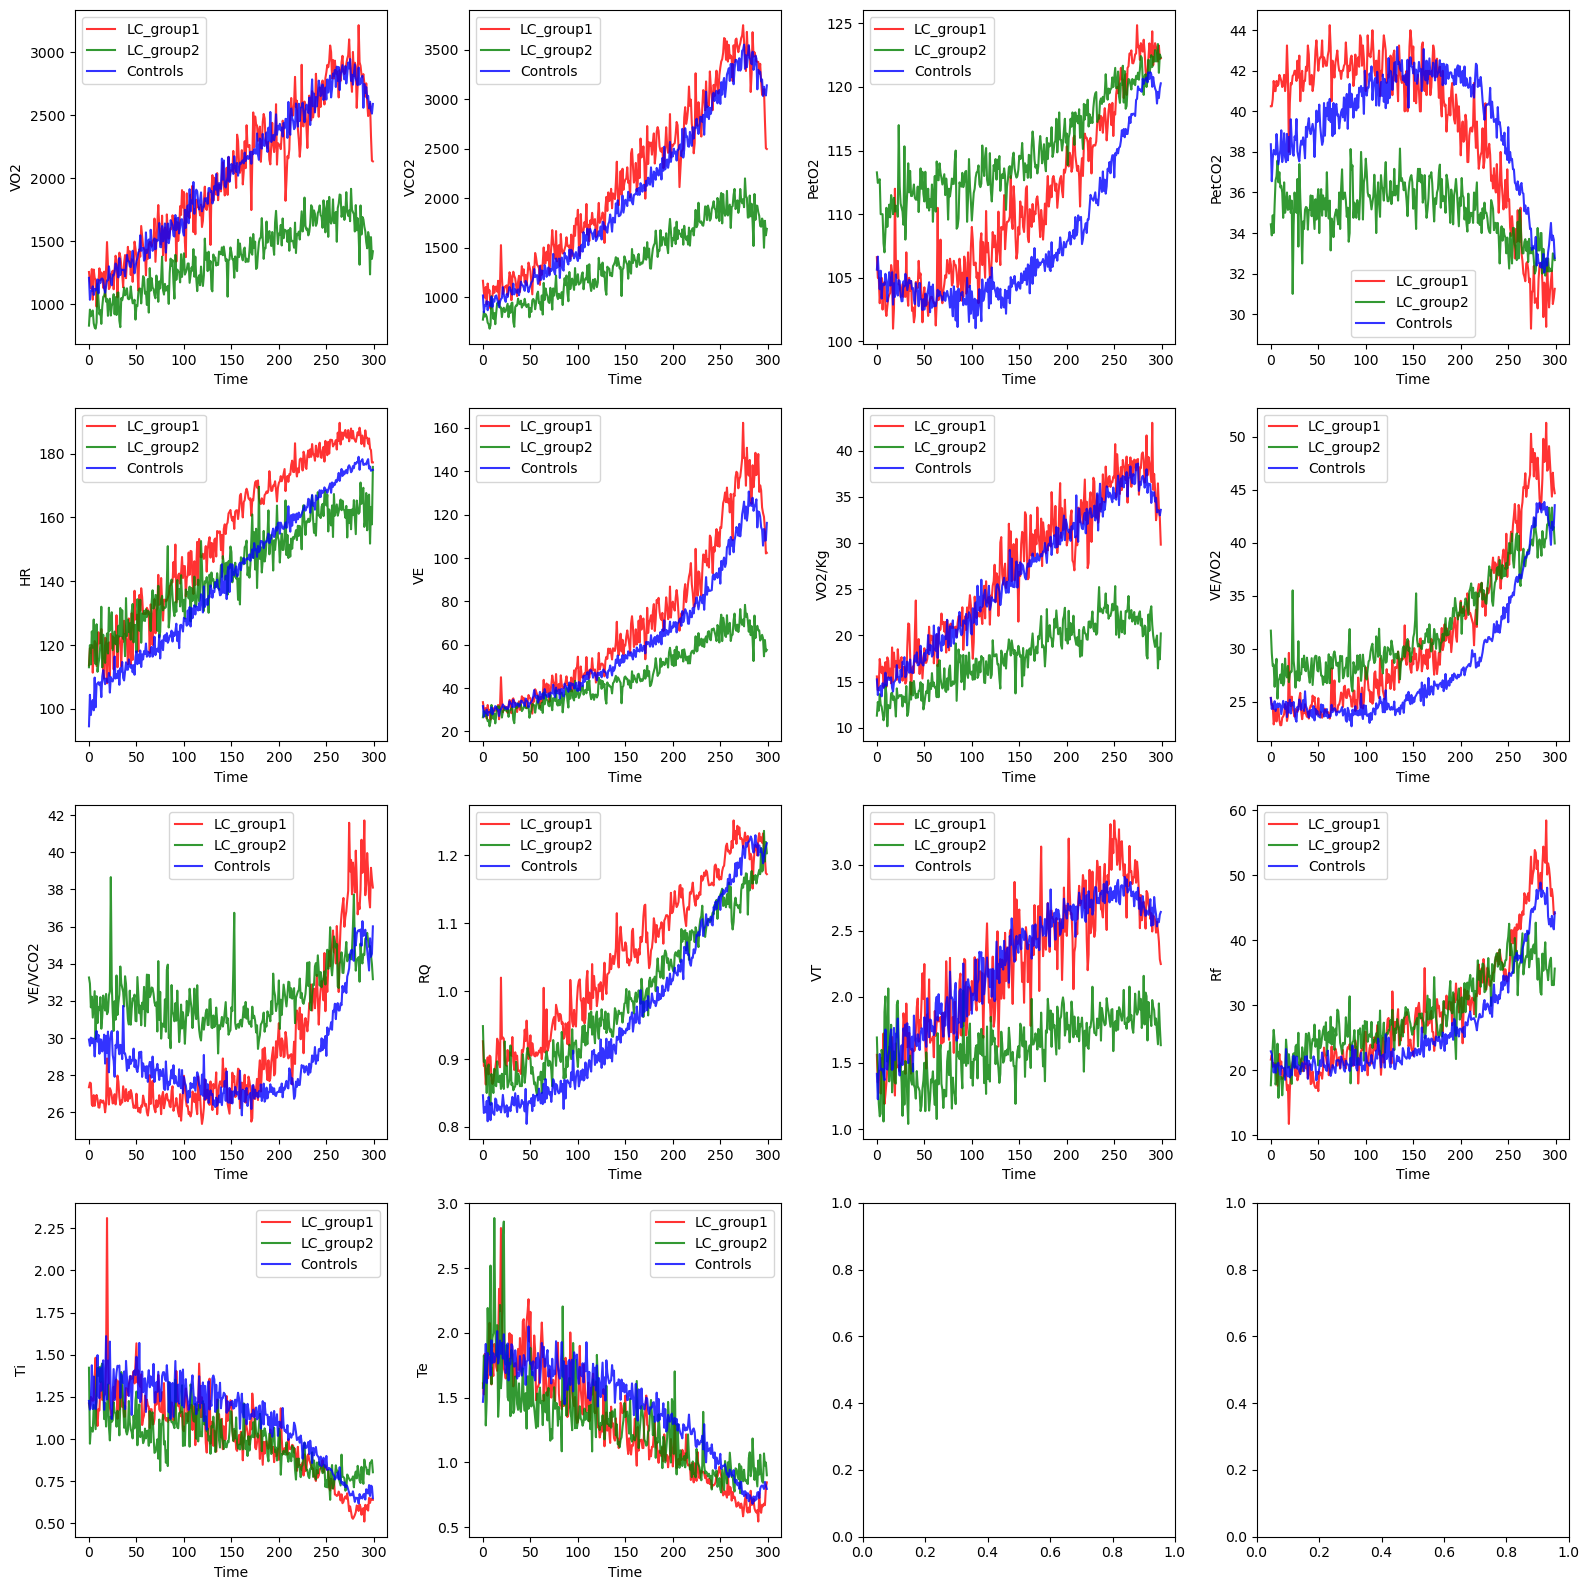

In [26]:
step_size = 300
LC_group1_names = ['LC_2', 'LC_3', 'LC_6', 'LC_9']
# LC_group2 is the rest of the LC group
#LC_group2_names = ['LC_3']
LC_group2_names = [name for name in df_exercise.index.unique()[df_exercise.index.unique().str.contains('LC')] if name not in LC_group1_names]
LC_exercise = df_exercise[df_exercise['Group'] == 'LC']
LC_group1 = LC_exercise[LC_exercise.index.isin(LC_group1_names)]
LC_group2 = LC_exercise[LC_exercise.index.isin(LC_group2_names)]
Co_exercise = df_exercise[df_exercise['Group'] == 'Controls']
step_size = 300

if 'Power' in feature_list == False:
    feature_list.append('Power')
# create a subplot for each feature for LC_group1, LC_group2, and Controls

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()

for idx, feature in enumerate(feature_list):
    ax = axs[idx]
    j = 0
    for groupname, df in zip(['LC_group1', 'LC_group2', 'Controls'], [LC_group1, LC_group2, Co_exercise]):
        t = copy.deepcopy(df['t'])
        df['t'] = df.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        df_points = df.groupby('t')[feature].mean()
        points = [0]
        for i in [x/step_size for x in range(1, step_size+1)]:
            points.append(df_points.index[df_points.index < i].tolist()[-1])
        df_points_mean = [df_points.loc[points[i]:points[i+1]].mean() for i in range(len(points)-1)]
        ax.plot(df_points_mean, label=groupname, color=['red', 'green', 'blue'][j], alpha=0.8)
        ax.set_xlabel('Time')
        ax.set_ylabel(feature)
        ax.legend()
        df['t'] = t
        j += 1

plt.tight_layout()

In [27]:
# statistical modeling using linear mixed effects model as above but with groups LC_group1, LC_group2, and Controls


step_size = 300

features = ['VO2', 'VCO2', 'PetO2', 'PetCO2', 'HR', 'VE', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te']
df_equalized = {}
for group, df_group in zip(['Controls', 'LC_group1', 'LC_group2'], [Co_exercise, LC_group1, LC_group2]):
    df_equal = pd.DataFrame()
    t = copy.deepcopy(df['t'])
    df_group['t'] = df_group.groupby('Participant')['t'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    for feature in features:
        df_points = df_group.groupby('t')[feature].mean()
        points = [0]
        for i in [x/step_size for x in range(1, step_size+1)]:
            points.append(df_points.index[df_points.index < i].tolist()[-1])
        df_points_mean = [df_points.loc[points[i]:points[i+1]].mean() for i in range(len(points)-1)]
        df_equal[feature] = df_points_mean
    df_equal['Group'] = group
    df_equalized[group] = df_equal

df_equalized = pd.concat(df_equalized.values(), axis=0)
df_equalized.reset_index(inplace=True)
df_equalized.rename(columns={'index': 't'}, inplace=True)
# rename df_equalized features with / to _ to avoid errors in the formula
df_equalized.columns = df_equalized.columns.str.replace('/', '_')
features = df_equalized.columns[1:-1]

p_values = []
# create a linear mixed effects model for each feature
for feature in features:
    model = smf.mixedlm(f"{feature} ~ Group * t", df_equalized, groups=df_equalized['Group'])
    result = model.fit()
    pvas = result.pvalues

    # also compare LC_group1 to LC_group2
    model = smf.mixedlm(f"{feature} ~ Group * t", df_equalized[df_equalized['Group'] != 'Controls'], groups=df_equalized[df_equalized['Group'] != 'Controls']['Group'])
    result = model.fit()
    pvas['LC_1:LC_2'] = result.pvalues['Group[T.LC_group2]']
    pvas['LC_1:LC_2 interact'] = result.pvalues['Group[T.LC_group2]:t']
    pvas.drop(['Intercept', 't', 'Group Var'], inplace=True)
    pvas.rename(index={'Group[T.LC_group1]': 'Controls: LC_1', 'Group[T.LC_group2]': 'Controls: LC_2', 'Group[T.LC_group1]:t': 'Controls: LC_1 interact', 'Group[T.LC_group2]:t': 'Controls: LC_2 interact'}, inplace=True)
    pvas = pvas[['Controls: LC_1', 'Controls: LC_2', 'LC_1:LC_2', 'Controls: LC_1 interact', 'Controls: LC_2 interact', 'LC_1:LC_2 interact']]
    _, corrected_pvals, _, _ = multipletests(pvas, alpha=0.05, method='fdr_bh')
    corrected_pvals = [round(pval, 4) for pval in corrected_pvals]
    corrected_pvals = [f'{pval}**' if pval < 0.01 else f'{pval}*' if pval < 0.05 else pval for pval in corrected_pvals]
    p_values.append(corrected_pvals)

# create a dataframe with the p-values
df_pvals = pd.DataFrame(p_values, columns=pvas.index, index=features)
# to excel
df_pvals.to_excel('p_values_EC.xlsx')
